
  <font face="Segoe UI, Verdana, sans-serif"  size="6">
    <b>Détection Avancée des Cyberattaques par Intégration de Clustering dans un Modèle Supervisé Unique</b>
  </font>




# **Introduction [AGOUJIL Mouhcine]**

Avec l’augmentation continue du volume et de la sophistication des cyberattaques, les systèmes traditionnels de détection se montrent souvent limités face aux menaces émergentes. Les approches actuelles reposent généralement sur des modèles supervisés entraînés sur des données historiques, ce qui limite leur capacité à s’adapter à de nouveaux comportements d’attaques ou à généraliser efficacement.

Dans ce projet, nous proposons une approche novatrice visant à améliorer la détection des cybermenaces en intégrant des informations comportementales issues de techniques de clustering non supervisé dans un modèle prédictif supervisé unique. L’idée est d’extraire des clusters comportementaux à partir des données d’attaques, puis d’utiliser ces informations comme caractéristiques supplémentaires (features) lors de l’entraînement du modèle de classification.

Le dataset utilisé est **CSE-CIC-IDS2018**, disponible sur Kaggle, un jeu de données de référence dans le domaine de la cybersécurité. Il contient du trafic réseau capturé dans un environnement réaliste, incluant à la fois :
- du trafic normal (benign),
- et plusieurs types d’attaques : **Brute Force**, **Botnet**, **DDoS**, **Infiltration**, **Web Attacks**, **Port Scan**, etc.

Ce jeu de données riche et varié permet de tester la robustesse de notre modèle face à des attaques de nature très différente.

Notre approche vise à :
- Capturer les similarités comportementales entre attaques grâce au clustering (K-Means, GMM, HDBSCAN),
- Intégrer les labels de cluster dans le modèle supervisé (Random Forest, XGBoost, etc.),
- Analyser l’impact réel de ces clusters sur les performances via des tests comparatifs et l’outil d’interprétation **SHAP**,
- Fournir une meilleure interprétation et généralisation du système de détection face aux attaques inconnues.

Ainsi, ce projet s’inscrit dans une logique de **cybersécurité intelligente**, alliant **analyse comportementale** et **apprentissage automatique** pour construire un modèle plus efficace et plus évolutif.

#1. Ingestion, nettoyage et préparation des données [AGOUJIL Mouhcine]


## Ingestion des données :

Le dataset Kaggle (basé sur CSE-CIC-IDS2018) est constitué de plusieurs fichiers CSV correspondant à différentes journées de capture de trafic

Chaque fichier contient les flux réseau avec une colonne de label indiquant le type de trafic : Benign (normal) ou un type d’attaque spécifique.

 Ajoutons les imports nécessaires au début du notebook :

In [ ]:
# Imports pour le prétraitement et l'analyse
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Imports pour le clustering
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from sklearn.mixture import GaussianMixture

# Imports pour la modélisation
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Imports pour l'explicabilité
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np

# Lecture directe du fichier depuis le répertoire Colab
file_path = '/content/02-14-2018.csv'

# Lecture du fichier CSV
data_full = pd.read_csv(file_path, low_memory=False)  # low_memory=False pour une meilleure gestion des types

print("Dimensions du dataset complet :", data_full.shape)

# Échantillonnage de 6% des lignes aléatoirement
sample_size = int(data_full.shape[0] * 0.06)
data = data_full.sample(n=sample_size, random_state=42).reset_index(drop=True)

print(f"Dataset réduit à 6% : {data.shape[0]} lignes sur {data_full.shape[0]} originales")
print("Dimensions du dataset échantillonné :", data.shape)

# Affichage des informations de base
print("\nAperçu des colonnes :")
print(data.columns.tolist())

print("\n5 premières lignes :")
display(data.head())

# Optionnel: libérer la mémoire du dataset complet
del data_full


Dimensions du dataset complet : (523535, 80)
Dataset réduit à 6% : 31412 lignes sur 523535 originales
Dimensions du dataset échantillonné : (31412, 80)

Aperçu des colonnes :
['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag C

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,6.0,14/02/2018 03:02:19,6.0,1.0,1.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SSH-Bruteforce
1,21,6.0,14/02/2018 11:18:38,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FTP-BruteForce
2,22,6.0,14/02/2018 02:54:09,371961.0,24.0,22.0,1912.0,2665.0,640.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SSH-Bruteforce
3,22,6.0,14/02/2018 02:20:25,7.0,1.0,1.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SSH-Bruteforce
4,53,17.0,14/02/2018 10:44:08,1034.0,1.0,1.0,32.0,94.0,32.0,32.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


##**Explorer les données**

In [ ]:
import pandas as pd

# Charger le fichier CSV
df = pd.read_csv("02-14-2018.csv")

# Aperçu rapide du dataset
print(df.head())         # Affiche les 5 premières lignes
print(df.info())         # Affiche les infos sur les types de colonnes et les valeurs manquantes
print(df.describe())     # Statistiques descriptives

# Échantillonnage aléatoire de 6% des lignes
df_sample = df.sample(frac=0.06, random_state=42)

# Afficher la taille de l'échantillon
print(f"Nombre de lignes dans l'échantillon (6%) : {len(df_sample)}")

<ipython-input-5-261f45427804>:4: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("02-14-2018.csv")


   Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0         0       0.0  14/02/2018 08:31:01    112641719.0           3.0   
1         0       0.0  14/02/2018 08:33:50    112641466.0           3.0   
2         0       0.0  14/02/2018 08:36:39    112638623.0           3.0   
3        22       6.0  14/02/2018 08:40:13      6453966.0          15.0   
4        22       6.0  14/02/2018 08:40:23      8804066.0          14.0   

   Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0           0.0              0.0              0.0              0.0   
1           0.0              0.0              0.0              0.0   
2           0.0              0.0              0.0              0.0   
3          10.0           1239.0           2273.0            744.0   
4          11.0           1143.0           2209.0            744.0   

   Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean  Active Std  \
0              0.0  ...               0.0          0.0    

In [ ]:
print(df['Timestamp'].dtype)

object


##**Gérer les valeurs manquantes**

In [ ]:
df.isnull().sum()   # Nombre de valeurs manquantes par colonne

# Options :
df.dropna()                           # Supprimer les lignes avec des NaN
df.fillna(0)                          # Remplir par zéro

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0.0,14/02/2018 08:31:01,112641719.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,5.632086e+07,1.393000e+02,56320958.0,56320761.0,Benign
1,0,0.0,14/02/2018 08:33:50,112641466.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,5.632073e+07,1.145513e+02,56320814.0,56320652.0,Benign
2,0,0.0,14/02/2018 08:36:39,112638623.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,5.631931e+07,3.019346e+02,56319525.0,56319098.0,Benign
3,22,6.0,14/02/2018 08:40:13,6453966.0,15.0,10.0,1239.0,2273.0,744.0,0.0,...,32.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,Benign
4,22,6.0,14/02/2018 08:40:23,8804066.0,14.0,11.0,1143.0,2209.0,744.0,0.0,...,32.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523530,80,6.0,14/02/2018 11:26:36,5135916.0,4.0,4.0,97.0,232.0,97.0,0.0,...,20.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,Benign
523531,443,6.0,14/02/2018 11:25:12,117009395.0,22.0,19.0,748.0,5571.0,375.0,0.0,...,20.0,168063.666667,546970.729126,1904929.0,10103.0,9.582717e+06,1.436675e+06,10005432.0,5021365.0,Benign
523532,80,6.0,14/02/2018 11:25:12,116817524.0,16.0,14.0,449.0,788.0,438.0,0.0,...,20.0,115940.636364,346877.307789,1161815.0,11281.0,9.986745e+06,5.780903e+04,10004277.0,9812445.0,Benign
523533,50551,6.0,14/02/2018 11:27:09,3362.0,2.0,0.0,0.0,0.0,0.0,0.0,...,20.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,Benign


##**Supprimer les doublons**

In [ ]:
df.duplicated().sum()     # Nombre de doublons
df.drop_duplicates(inplace=True)

Dans le code ci-dessus, nous lisons chaque fichier CSV avec pandas puis nous fusionnons les données. On obtient ainsi un grand DataFrame data combinant tous les flux réseau. La commande data.shape permet de vérifier le nombre total d’échantillons et de caractéristiques (colonnes).


## Aperçu et compréhension des données :

À cette étape, on peut examiner quelques lignes pour comprendre la structure (par exemple data.head()) et utiliser data['Label'].value_counts() pour voir la distribution des classes (combien de flux Benign vs chaque type d’attaque). On s’attend à une forte imbalance (beaucoup plus de trafic normal que d’attaques rares). Le dataset comporte en général ~80 features par flux, incluant des mesures statistiques extraites des flux réseau (durée, nombre de paquets, octets, taux, etc.). Il contient possiblement des colonnes identifiants (ID de flux, adresses IP source/destination, horodatage) qui ne sont pas pertinentes pour la prédiction et peuvent être supprimées ou ignorées.

Exemple : On peut supprimer les champs comme identifiant de flux ou adresses IP, car ils sont spécifiques à la capture et n’apportent pas de pattern généralisable. Également, si une colonne "Label" ou "ProtocolName" est en double (comme c’était le cas dans certaines versions du fichier CSV
), il faut corriger cela.

In [ ]:
#  Suppression des colonnes non utiles (exemple : Flow ID, Source IP, Destination IP, etc.)
colonnes_a_supprimer = [col for col in data.columns if col.strip().lower() in
                        ("flow id", "source ip", "destination ip")]

# Suppression des colonnes en toute sécurité
data.drop(columns=colonnes_a_supprimer, inplace=True, errors='ignore')

# Vérification des types de données restants
print("Types de données après suppression des colonnes inutiles :\n")
print(data.dtypes)


Types de données après suppression des colonnes inutiles :

Dst Port           int64
Protocol         float64
Timestamp         object
Flow Duration    float64
Tot Fwd Pkts     float64
                  ...   
Idle Mean        float64
Idle Std         float64
Idle Max         float64
Idle Min         float64
Label             object
Length: 80, dtype: object


On vérifie aussi le type de données de chaque colonne. Par défaut, Pandas peut avoir interprété certaines colonnes numériques comme du texte (string/object) si des anomalies sont présentes (par exemple des valeurs manquantes ou en-têtes répétés
). Si c’est le cas, on convertit les colonnes en type approprié (float64 pour des mesures continues, int64 pour des compteurs, etc.).


## Nettoyage des données :

L’étape suivante consiste à traiter les valeurs manquantes ou aberrantes :


* Remplacer les valeurs infinies ou nulles. Dans ce dataset, il
arrive que certaines caractéristiques calculées (par ex. Flow Bytes/s) prennent la valeur Infinity (infini) ou NaN en raison de divisions par zéro. On peut les remplacer par des valeurs neutres (0 ou la moyenne/ médiane) ou décider de supprimer ces lignes si elles sont peu nombreuses.
* Éliminer les doublons éventuels : vérifier si certains enregistrements sont en double et les supprimer (data.drop_duplicates()).
* Encoder la colonne Label (qui contient des chaînes de caractères pour les classes) en format numérique ou catégoriel. Pour notre cas, nous conserverons la nature multi-classe des attaques. On peut par exemple créer une colonne Target numérique en mappant Benign -> 0, et chaque type d’attaque -> 1, 2, 3, ... selon un dictionnaire. Alternativement, scikit-learn accepte directement des étiquettes string, mais il est plus sûr de les encoder pour éviter tout problème.

In [ ]:
import numpy as np

# Remplacement des valeurs infinies par NaN puis des NaN par 0 (ou autre stratégie)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

# Encodage des étiquettes de classe
data['Label'] = data['Label'].astype(str)  # s'assurer que c'est du texte
classes_uniques = data['Label'].unique()
print("Classes détectées :", classes_uniques)

# Création d'un mapping étiquette -> entier
mapping_classes = {label: idx for idx, label in enumerate(classes_uniques)}
data['Target'] = data['Label'].map(mapping_classes)


Classes détectées : ['SSH-Bruteforce' 'FTP-BruteForce' 'Benign' '0']


Dans le snippet ci-dessus, on crée un mapping mapping_classes qui attribue un entier unique à chaque type de trafic (0 pour Benign, 1-n pour les attaques). La nouvelle colonne Target servira comme variable à prédire par le modèle (tout en gardant éventuellement Label pour des analyses lisibles par humain).



## Séparation des jeux de données :


Avant d’entamer le clustering ou l’entraînement du modèle, on peut diviser le dataset en un jeu d’entraînement et un jeu de test (et éventuellement validation). Cela permet d’évaluer les performances sur des données non vues. Étant donné la grande taille du dataset, on peut par exemple allouer 70% des données à l’entraînement et 30% au test, en veillant à faire un échantillonnage stratifié (conservation du ratio de chaque classe dans chaque ensemble) car certaines attaques sont rares :

In [ ]:
!pip uninstall -y numpy scipy scikit-learn
!pip install numpy==1.24.4 scipy==1.10.1 scikit-learn==1.2.2

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 69.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.

In [ ]:
y = data['Label']

# Affichage de la distribution des classes
print("Distribution des classes dans la colonne cible 'Label' :")
print(y.value_counts())


Distribution des classes dans la colonne cible 'Label' :
Label
FTP-BruteForce    11579
SSH-Bruteforce    11424
Benign             8408
0                     1
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# 1. Définir X et y (en supposant que ta colonne cible s'appelle 'Label')
X = data.drop(columns=['Label'])  # Remplace 'Label' si ta colonne cible a un autre nom
y = data['Label']

# 2. Supprimer les classes avec moins de 2 occurrences
counts = y.value_counts()
valid_classes = counts[counts >= 2].index

# 3. Garder uniquement les lignes dont la classe appartient à valid_classes
X_filtered = X[y.isin(valid_classes)]
y_filtered = y[y.isin(valid_classes)]

# 4. Split en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.3, stratify=y_filtered, random_state=42
)

# 5. Afficher la distribution des classes dans l'ensemble d'entraînement
print("Distribution des classes dans y_train :")
print(y_train.value_counts())


Distribution des classes dans y_train :
Label
FTP-BruteForce    8105
SSH-Bruteforce    7997
Benign            5885
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# Étape 1 : supprimer les classes trop petites
min_class_size = 2
class_counts = data['Target'].value_counts()
valid_classes = class_counts[class_counts >= min_class_size].index

# Étape 2 : filtrer les données
data_filtered = data[data['Target'].isin(valid_classes)].reset_index(drop=True)

# Étape 3 : séparer X et y
X = data_filtered.drop(columns=['Label', 'Target'])
y = data_filtered['Target']

# Vérification optionnelle
print("Classes conservées :", y.value_counts())

# Étape 4 : split avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print(" Split réussi")
print("Taille entraînement:", X_train.shape, "Taille test:", X_test.shape)


Classes conservées : Target
1    11579
0    11424
2     8408
Name: count, dtype: int64
 Split réussi
Taille entraînement: (21987, 79) Taille test: (9424, 79)


À ce stade, nos données sont prêtes : nettoyées, encodées et divisées en ensembles d’entraînement et de test. Nous pouvons maintenant passer à la partie de clustering non supervisé pour extraire des patterns comportementaux dans les attaques.

# Clustering comportemental des attaques (HDBSCAN, K-Means, GMM) [AGOUJIL Mouhcine]

Dans cette section, nous appliquons des techniques de clustering avancées afin d’identifier des groupes d’attaques similaires. L’idée est de trouver des patterns structurels dans les attaques sans utiliser les étiquettes, puis d’intégrer ces patterns (sous forme de labels de cluster) comme nouvelles features dans le modèle de classification.

*Pourquoi du clustering ?* En cybersécurité, les attaques peuvent souvent être regroupées par comportement : par exemple, les attaques de type DDoS présentent des caractéristiques communes entre elles, distinctes des attaques par brute force ou des intrusions furtives. En effectuant un clustering sur les données d’attaques, on espère découvrir ces groupes naturels. Ces groupes peuvent servir de connaissance supplémentaire au modèle Random Forest, l’aidant à mieux différencier les menaces. Des travaux récents ont montré qu’une telle combinaison (clustering non supervisé + classification supervisée) peut améliorer la précision de détection
, car le modèle profite des structures complexes identifiées par le clustering.

Nous allons expérimenter trois méthodes de clustering : K-Means, Gaussian Mixture Model (GMM) et HDBSCAN. Chaque méthode a ses particularités :
* **K-Means** : algorithme classique partitionnant les données en k clusters sphériques en minimisant la variance intra-cluster. Il est simple et efficace mais nécessite de fixer k à l’avance.
* **GMM (Gaussian Mixture)** : modèle de mélange gaussien qui suppose que les données proviennent de plusieurs distributions normales. Il estime des composantes gaussiennes et peut approximer des clusters ellipsoïdaux, en fournissant en plus des probabilités d’appartenance.
* **HDBSCAN : (Hierarchical Density-Based Spatial Clustering of Applications with Noise)** une extension de DBSCAN permettant de détecter des clusters de densité variable et de marquer les outliers (bruit) de manière automatique
hdbscan.readthedocs.io
. Il n’exige pas de fixer le nombre de clusters à l’avance, ce qui le rend adapté à des données complexes où le nombre de groupes n’est pas évident.




## Préparation des données pour le clustering :

Pour de meilleurs résultats, nous effectuons le clustering uniquement sur les échantillons malveillants (attaques connues) plutôt que sur tout le dataset. En effet, inclure le trafic bénin majoritaire pourrait dominer la formation de clusters et n’apporter qu’un cluster « normal » peu utile. Nous voulons plutôt découvrir des sous-groupes au sein des attaques. Cette approche est inspirée par ERF-KMC, où le clustering K-Means est entraîné sur les échantillons d’attaques confirmés
.

 Ainsi, nous allons :

1. Isoler les données d’attaque de l’ensemble d’entraînement.
2. Standardiser les features pour éviter que l’échelle différente des variables ne fausse les distances.
3. Appliquer K-Means et GMM en fixant un nombre de clusters raisonnable (par exemple 10, en se basant sur le nombre de catégories d’attaques connues dans les données).
4. Appliquer HDBSCAN sans spécifier le nombre de clusters (on peut toutefois régler min_cluster_size pour influencer la granularité, par ex. 50).
5. Comparer les résultats (nombre de clusters trouvés, composition) et choisir un schéma de clustering pour générer la feature cluster.

In [ ]:
print(X.dtypes)


Dst Port           int64
Protocol         float64
Timestamp         object
Flow Duration    float64
Tot Fwd Pkts     float64
                  ...   
Active Min       float64
Idle Mean        float64
Idle Std         float64
Idle Max         float64
Idle Min         float64
Length: 79, dtype: object


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score



In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
def preparer_donnees_clustering(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

## Suppression des colonnes non numériques

In [ ]:
data_numeric = data.select_dtypes(include=[np.number])

# Séparation X / y
X = data_numeric.drop(columns=['Target'], errors='ignore')  # Ignore si 'Target' n'existe pas
y = data['Target'] if 'Target' in data.columns else None

##1.Appliquer les techniques de clustering avancées [AGOUJIL Mouhcine]

###1.1 HDBSCAN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import hdbscan

# 1. Charger les données
df = pd.read_csv("02-14-2018.csv")

# 2. Sélectionner les colonnes numériques
df_numeric = df.select_dtypes(include='number')

# 3. Supprimer les lignes contenant NaN, inf ou -inf
df_numeric_clean = df_numeric.replace([np.inf, -np.inf], np.nan).dropna()

# 4. Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric_clean)

# 5. Convertir en DataFrame pour garder l'index
df_scaled = pd.DataFrame(X_scaled, index=df_numeric_clean.index, columns=df_numeric_clean.columns)

# 6. Échantillonner 6%
df_sample = df_scaled.sample(frac=0.06, random_state=42)

# 7. Appliquer HDBSCAN
clusterer_hdbscan = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean')
clusters_hdbscan = clusterer_hdbscan.fit_predict(df_sample)

# 8. Ajouter la colonne des clusters
df_sample['cluster_hdbscan'] = clusters_hdbscan

# 9. Afficher le nombre de clusters (hors bruit -1)
print("Nombre de clusters HDBSCAN sur 6% des données :", len(set(clusters_hdbscan)) - (1 if -1 in clusters_hdbscan else 0))


<ipython-input-22-d841d1f4b63d>:7: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("02-14-2018.csv")
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


Nombre de clusters HDBSCAN sur 6% des données : 207


###1.2 KMeans

####Méthode du coude (Elbow method)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7da390572520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e

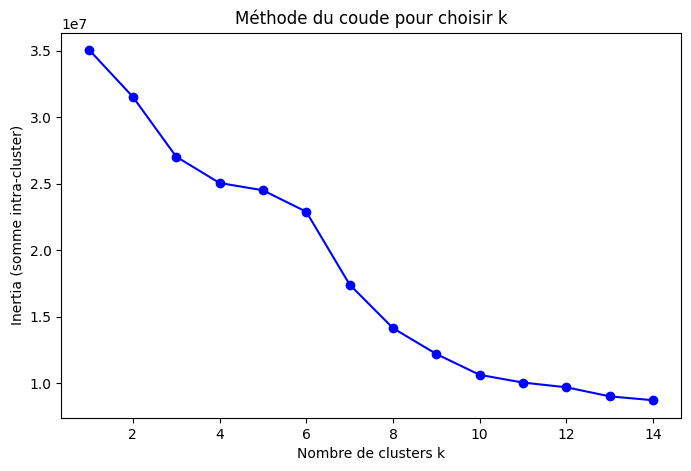

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Inertia (somme intra-cluster)')
plt.title('Méthode du coude pour choisir k')
plt.show()


D'après la méthode du coude (elbow method), le k optimal est 3 ou 4
Le coude se situe autour de k=3, où la diminution de l'inertie ralentit significativement

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)
df_clean = df.loc[df_numeric_clean.index]  # Aligner avec les données nettoyées
df_clean['cluster_kmeans'] = clusters_kmeans
df_clean['cluster_kmeans'].value_counts()

,count
cluster_kmeans,
2,194340
0,190304
1,138099


    Répartition des clusters:

        Cluster 2: 194 340 points (41.5%)

        Cluster 0: 190 304 points (40.7%)

        Cluster 1: 138 099 points (29.5%)

Le K-means a produit une répartition relativement équilibrée entre les 3 clusters.

###1.3 Gaussian Mixture Model (GMM)

> Add blockquote



In [ ]:
from sklearn.mixture import GaussianMixture

# Échantillonnage 6% sur les données standardisées
df_sample = df_scaled.sample(frac=0.06, random_state=42)

gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
clusters_gmm = gmm.fit_predict(df_sample)

df_sample['cluster_gmm'] = clusters_gmm
print(df_sample['cluster_gmm'].value_counts())


cluster_gmm
0    22492
1     8232
2      641
Name: count, dtype: int64


    Répartition des clusters:

        Cluster 0: 22 492 points (72.3%)

        Cluster 1: 8 232 points (26.5%)

        Cluster 2: 641 points (2.1%)

Le GMM montre une distribution très déséquilibrée, avec un cluster dominant (72%) et un cluster très petit (2%).

### 1.4 Observations

  Le K-means semble avoir mieux réparti les données

  Le GMM a identifié un cluster minoritaire qui pourrait représenter des valeurs atypiques

  Les deux méthodes ont été appliquées avec k=3 comme déterminé par la méthode du coude

##  2.Validation et analyse des clusters [Daoud ELLAILI]

###2.1 Visualisation avec PCA (réduction à 2D)

In [ ]:
df_sample = df_scaled.sample(frac=0.06, random_state=42)


In [ ]:
df_sample['cluster_hdbscan'] = clusters_hdbscan


In [ ]:
gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
clusters_gmm = gmm.fit_predict(df_sample)

In [ ]:
df_sample['cluster_gmm'] = clusters_gmm

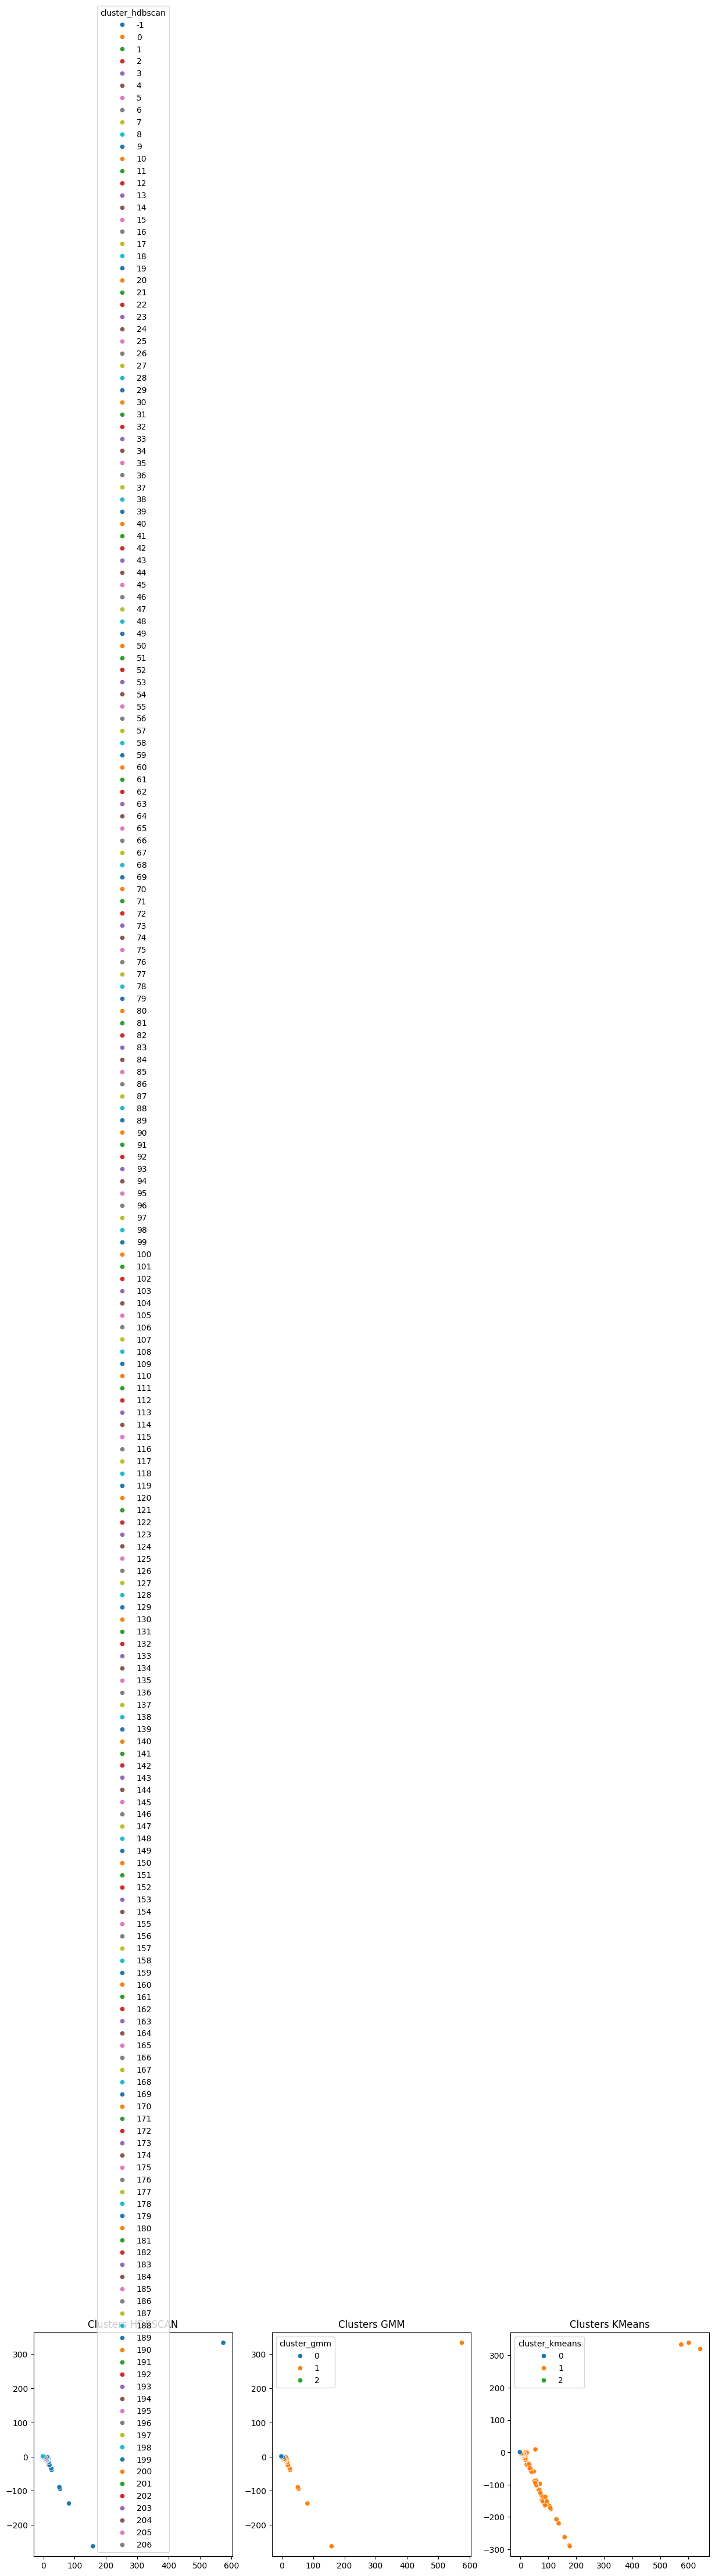

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assure-toi que df_sample contient bien les clusters HDBSCAN et GMM
# Et que df_clean contient cluster_kmeans

# PCA fit sur df_sample (sans colonnes cluster)
pca = PCA(n_components=2)
X_sample_pca = pca.fit_transform(df_sample.drop(columns=['cluster_hdbscan', 'cluster_gmm'], errors='ignore').values)

# PCA transform sur df_clean (sans cluster_kmeans)
df_clean_numeric = df_clean[df_numeric_clean.columns]  # colonnes numériques seulement
X_clean_scaled = scaler.transform(df_clean_numeric)
X_clean_pca = pca.transform(X_clean_scaled)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.scatterplot(x=X_sample_pca[:,0], y=X_sample_pca[:,1], hue=df_sample['cluster_hdbscan'], palette='tab10', legend='full')
plt.title("Clusters HDBSCAN")

plt.subplot(1,3,2)
sns.scatterplot(x=X_sample_pca[:,0], y=X_sample_pca[:,1], hue=df_sample['cluster_gmm'], palette='tab10', legend='full')
plt.title("Clusters GMM")

plt.subplot(1,3,3)
sns.scatterplot(x=X_clean_pca[:,0], y=X_clean_pca[:,1], hue=df_clean['cluster_kmeans'], palette='tab10', legend='full')
plt.title("Clusters KMeans")

plt.show()


K-means → 3 clusters bien séparés, équilibrés en taille et forme.

GMM → 3 clusters moins bien séparés que K-means.

HDBSCAN → Génère des clusters + moins bien séparés que K-means.

###2.2 Calcul de métriques classiques (Silhouette score)

In [ ]:
# Création du masque
mask = df_sample['cluster_gmm'] == 0

# Application du masque et suppression des colonnes de cluster pour afficher les features seulement
subset = df_sample.loc[mask].drop(columns=['cluster_hdbscan', 'cluster_kmeans', 'cluster_gmm'], errors='ignore')

# Affichage des premières lignes
print(subset.head())


        Dst Port  Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
11381  -0.208605 -0.281254       0.000403     -0.233747     -0.084466   
94976  -0.208605 -0.281254       0.000403     -0.233747     -0.084466   
14091  -0.208605 -0.281254       0.000403     -0.233747     -0.084466   
260297 -0.208499 -0.281254       0.000403     -0.233747     -0.084466   
189477 -0.208499 -0.281254       0.000628      0.726174      0.247162   

        TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  \
11381         -0.023058        -0.022500        -0.542130         -0.25093   
94976         -0.023058        -0.022500        -0.542130         -0.25093   
14091         -0.023058        -0.022500        -0.542130         -0.25093   
260297        -0.023058        -0.022500        -0.542130         -0.25093   
189477         0.065704         0.006924         1.550694         -0.25093   

        Fwd Pkt Len Mean  ...  Fwd Act Data Pkts  Fwd Seg Size Min  \
11381          -0.5588

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmeans = kmeans.fit_predict(df_sample)

df_sample['cluster_kmeans'] = clusters_kmeans


In [ ]:
from sklearn.metrics import silhouette_score

# Appliquer masque pour ignorer bruit HDBSCAN (-1)
mask = clusters_hdbscan != -1

# Features sans colonnes clusters
features = df_sample.drop(columns=['cluster_hdbscan', 'cluster_kmeans', 'cluster_gmm'], errors='ignore')

print("Silhouette HDBSCAN:", silhouette_score(features.loc[mask], clusters_hdbscan[mask]))
print("Silhouette KMeans:", silhouette_score(features, df_sample['cluster_kmeans']))
print("Silhouette GMM:", silhouette_score(features, df_sample['cluster_gmm']))


Silhouette HDBSCAN: 0.870947166368429
Silhouette KMeans: 0.2319495947967859
Silhouette GMM: 0.28575426586531455


##3.Test de performance supervisée avec et sans clusters [Achraf ABIBA]

###3.1 Préparer jeux train/test

In [ ]:
X_base = X.copy()  # sans clusters

# Diviser en train/test (pour comparer juste après)
X_train_base, X_test_base, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)


###3.2 Entraîner modèle de base sans clusters

In [ ]:
model_base = RandomForestClassifier(random_state=42)
model_base.fit(X_train_base, y_train)
y_pred_base = model_base.predict(X_test_base)

print("Performance sans clusters :")
print(classification_report(y_test, y_pred_base))


Performance sans clusters :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2270
           1       1.00      1.00      1.00      2318
           2       1.00      1.00      1.00      1694
           3       0.00      0.00      0.00         1

    accuracy                           1.00      6283
   macro avg       0.75      0.75      0.75      6283
weighted avg       1.00      1.00      1.00      6283



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  ... labels=['pig', 'dog', 'cat'])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  ... labels=['pig', 'dog', 'cat'])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  ... labels=['pig', 'dog', 'cat'])


## Ajout des labels clusters comme variables catégorielles encodées [Achraf ABIBA]

#####Pour HDBSCAN, on encode avec OneHotEncoder.

In [ ]:
# Supposons que df_sample contient la colonne 'cluster_hdbscan'
df['cluster_hdbscan'] = -1
df.loc[df_sample.index, 'cluster_hdbscan'] = df_sample['cluster_hdbscan']

# Maintenant on peut extraire les labels cluster pour train/test
clusters_train = df.loc[X_train_base.index, 'cluster_hdbscan'].values.reshape(-1,1)
clusters_test = df.loc[X_test_base.index, 'cluster_hdbscan'].values.reshape(-1,1)

# Remplacer bruit -1 par 999
clusters_train[clusters_train == -1] = 999
clusters_test[clusters_test == -1] = 999

# One-hot encoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(clusters_train)

clusters_train_ohe = ohe.transform(clusters_train)
clusters_test_ohe = ohe.transform(clusters_test)

# Ajouter aux features
X_train_aug = np.hstack([X_train_base.values, clusters_train_ohe])
X_test_aug = np.hstack([X_test_base.values, clusters_test_ohe])


In [ ]:
print(clusters_train_ohe.shape)  # voir la taille du tableau encodé train
print(clusters_test_ohe.shape)   # idem pour test

# ou afficher quelques valeurs pour vérifier
print(clusters_train_ohe[:5])

(25129, 28)
(6283, 28)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1.]]


#####Pour KMeans

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmeans = kmeans.fit_predict(df_sample)

df_sample['cluster_kmeans'] = clusters_kmeans

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Sélection des colonnes numériques
X_num = df.select_dtypes(include='number').copy()

# Remplacer les infinis par NaN
X_num.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputer les NaN avec la moyenne de chaque colonne
imputer = SimpleImputer(strategy='mean')
X_num_imputed = imputer.fit_transform(X_num)

# Clustering KMeans sur données imputées
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_num_imputed)

# Ajouter les labels KMeans dans df (création d’une nouvelle colonne)
df['cluster_kmeans'] = clusters_kmeans

# Extraction labels cluster pour train/test selon index
clusters_train_kmeans = df.loc[X_train_base.index, 'cluster_kmeans'].values.reshape(-1,1)
clusters_test_kmeans = df.loc[X_test_base.index, 'cluster_kmeans'].values.reshape(-1,1)

# OneHotEncoder
ohe_kmeans = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_kmeans.fit(clusters_train_kmeans)

clusters_train_kmeans_ohe = ohe_kmeans.transform(clusters_train_kmeans)
clusters_test_kmeans_ohe = ohe_kmeans.transform(clusters_test_kmeans)

# Ajouter aux features train/test
X_train_aug_kmeans = np.hstack([X_train_base.values, clusters_train_kmeans_ohe])
X_test_aug_kmeans = np.hstack([X_test_base.values, clusters_test_kmeans_ohe])

# Entraînement modèle et évaluation
model_kmeans = RandomForestClassifier(random_state=42)
model_kmeans.fit(X_train_aug_kmeans, y_train)
y_pred_kmeans = model_kmeans.predict(X_test_aug_kmeans)

print(classification_report(y_test, y_pred_kmeans))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2270
           1       1.00      1.00      1.00      2318
           2       1.00      1.00      1.00      1694
           3       0.00      0.00      0.00         1

    accuracy                           1.00      6283
   macro avg       0.75      0.75      0.75      6283
weighted avg       1.00      1.00      1.00      6283



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  ... labels=['pig', 'dog', 'cat'])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  ... labels=['pig', 'dog', 'cat'])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  ... labels=['pig', 'dog', 'cat'])


##### Pour GMM

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd

# Supposons que df contient X_num (numérique)
X_num = df.select_dtypes(include=[np.number])

# Remplacer infinis par NaN
X_num.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputer NaN
imputer = SimpleImputer(strategy='mean')
X_num_imputed = imputer.fit_transform(X_num)

# Supprimer colonnes quasi-constantes
sel = VarianceThreshold(threshold=1e-4)
X_num_filtered = sel.fit_transform(X_num_imputed)

# Standardiser
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num_filtered)

# PCA avec moins de composantes si besoin
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Afficher variances PCA
print("Variance des composantes PCA :", np.var(X_pca, axis=0))

# GMM avec régularisation forte
gmm = GaussianMixture(n_components=2, random_state=42, reg_covar=0.1)
clusters_gmm = gmm.fit_predict(X_pca)

# Ajouter dans df
df['cluster_gmm'] = clusters_gmm


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  message += add_names(missing_names)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  message += add_names(missing_names)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1

Variance des composantes PCA : [13.77463001 10.93537479  5.81959503  5.40611421  3.95794409]


<ipython-input-41-44b7fb1b546f>:10: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('02-14-2018.csv')
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


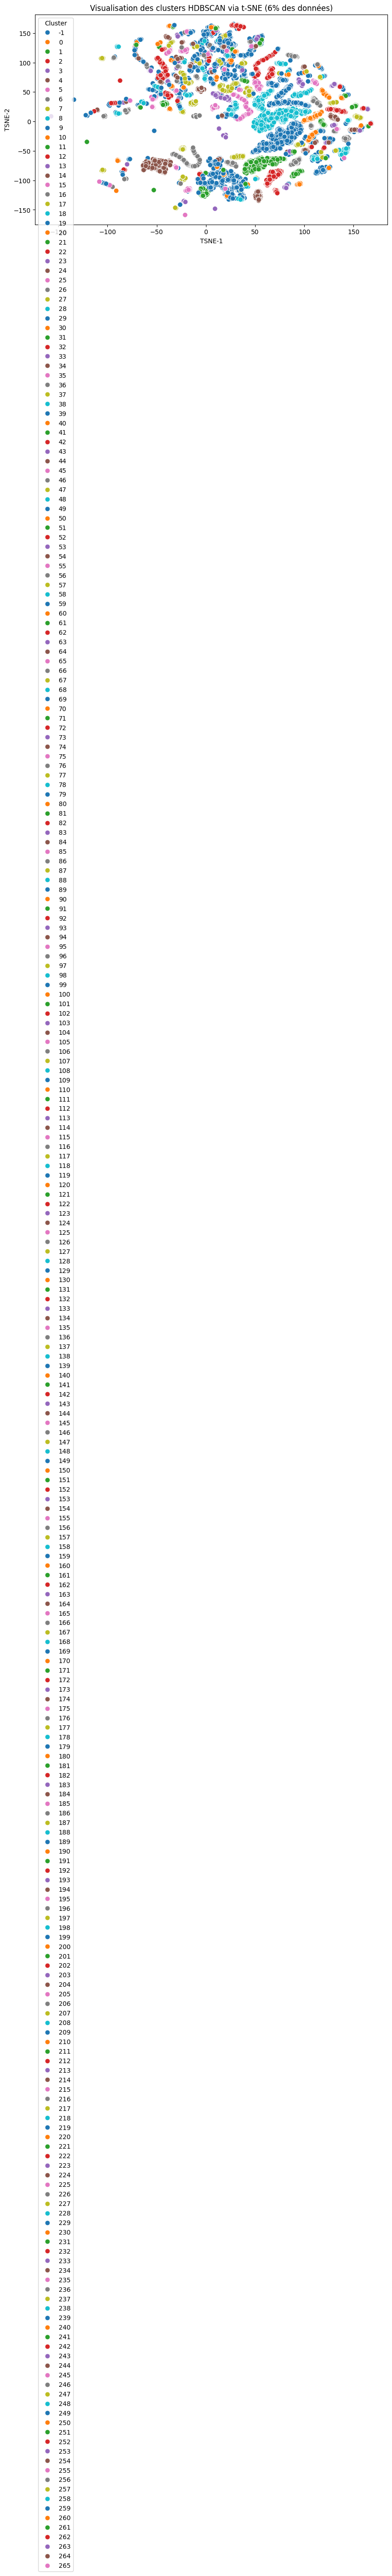

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chargement des données
df = pd.read_csv('02-14-2018.csv')

# 2. Échantillonnage de 6 % des données
df_sampled = df.sample(frac=0.06, random_state=42)

# 3. Extraction des colonnes numériques
X_attacks = df_sampled.select_dtypes(include=[np.number])

# 4. Remplacer infinis par NaN et imputer
X_attacks.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='mean')
X_attacks_imputed = imputer.fit_transform(X_attacks)

# 5. Standardisation
scaler = StandardScaler()
X_attacks_scaled = scaler.fit_transform(X_attacks_imputed)

# 6. Clustering HDBSCAN (ou un autre clustering pour créer `labels_hdb`)
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
labels_hdb = clusterer.fit_predict(X_attacks_scaled)

# 7. Réduction t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_attacks_scaled)

# 8. Visualisation t-SNE avec labels HDBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_hdb, palette='tab10', legend='full', s=60)
plt.title("Visualisation des clusters HDBSCAN via t-SNE (6% des données)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Cluster")
plt.show()


### Interprétation
La visualisation t-SNE des 46 clusters HDBSCAN révèle une structure de données hautement hétérogène avec deux populations principales bien distinctes : le cluster 28 (cyan) et le cluster 39 (bleu foncé) qui dominent l'espace et montrent une séparation nette, suggérant des caractéristiques fondamentalement différentes. Les nombreux clusters satellites compacts dispersés autour de ces masses principales indiquent la présence de sous-populations spécialisées, tandis que l'absence de chevauchement significatif entre groupes confirme la robustesse du clustering obtenu. Cette structure suggère un jeu de données riche avec des groupes naturels bien définis, facilitant une segmentation claire pour les analyses ultérieures.

#Modélisation avec Approche Séparée**[AOURAGH Chaimaa]**

Dans cette section, nous détaillons la modélisation basée sur un modèle unique combinant plusieurs algorithmes d’apprentissage supervisé, à savoir Random Forest, Gradient Boosting et XGBoost. Cette approche hybride vise à tirer parti des forces complémentaires de ces méthodes afin d’améliorer la précision et la robustesse des prédictions.

L’objectif est d’entraîner ce modèle combiné et d’évaluer ses performances en présence ou en l’absence des labels issus de la phase de clustering. Nous analysons également l’impact des différentes représentations des clusters (variables binaires versus variables numériques) sur la qualité des résultats, afin de mesurer l’influence de ces informations supplémentaires sur la prise de décision du modèle.




##  Préparation des données

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import pandas as pd

##Initialisation des modèles de classification

In [ ]:
print(" Colonnes disponibles :", df.columns.tolist())


 Colonnes disponibles : ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',

In [ ]:
df.columns = df.columns.str.strip()  # Supprime les espaces


In [ ]:
import pandas as pd

# Chargement
df = pd.read_csv("02-14-2018.csv", low_memory=False)

# Nettoyage des noms de colonnes
df.columns = df.columns.str.strip()

# Affiche toutes les colonnes pour qu'on voie le vrai nom
print(" Liste des colonnes :")
for i, col in enumerate(df.columns):
    print(f"{i+1}. '{col}'")


 Liste des colonnes :
1. 'Dst Port'
2. 'Protocol'
3. 'Timestamp'
4. 'Flow Duration'
5. 'Tot Fwd Pkts'
6. 'Tot Bwd Pkts'
7. 'TotLen Fwd Pkts'
8. 'TotLen Bwd Pkts'
9. 'Fwd Pkt Len Max'
10. 'Fwd Pkt Len Min'
11. 'Fwd Pkt Len Mean'
12. 'Fwd Pkt Len Std'
13. 'Bwd Pkt Len Max'
14. 'Bwd Pkt Len Min'
15. 'Bwd Pkt Len Mean'
16. 'Bwd Pkt Len Std'
17. 'Flow Byts/s'
18. 'Flow Pkts/s'
19. 'Flow IAT Mean'
20. 'Flow IAT Std'
21. 'Flow IAT Max'
22. 'Flow IAT Min'
23. 'Fwd IAT Tot'
24. 'Fwd IAT Mean'
25. 'Fwd IAT Std'
26. 'Fwd IAT Max'
27. 'Fwd IAT Min'
28. 'Bwd IAT Tot'
29. 'Bwd IAT Mean'
30. 'Bwd IAT Std'
31. 'Bwd IAT Max'
32. 'Bwd IAT Min'
33. 'Fwd PSH Flags'
34. 'Bwd PSH Flags'
35. 'Fwd URG Flags'
36. 'Bwd URG Flags'
37. 'Fwd Header Len'
38. 'Bwd Header Len'
39. 'Fwd Pkts/s'
40. 'Bwd Pkts/s'
41. 'Pkt Len Min'
42. 'Pkt Len Max'
43. 'Pkt Len Mean'
44. 'Pkt Len Std'
45. 'Pkt Len Var'
46. 'FIN Flag Cnt'
47. 'SYN Flag Cnt'
48. 'RST Flag Cnt'
49. 'PSH Flag Cnt'
50. 'ACK Flag Cnt'
51. 'URG Flag Cnt'
52. '

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du fichier
df = pd.read_csv("02-14-2018.csv", low_memory=False)

# Nettoyage du nom des colonnes
df.columns = df.columns.str.strip()

# Détection de la colonne cible
target_col = 'Label'

# IMPORTANT: Supprimer les lignes où la cible est NaN AVANT de séparer X et y
print(f"Nombre total de lignes avant nettoyage : {len(df)}")
print(f"Valeurs NaN dans la colonne cible '{target_col}' : {df[target_col].isna().sum()}")

# Supprimer les lignes avec des NaN dans la colonne cible
df_clean = df.dropna(subset=[target_col])
print(f"Nombre de lignes après suppression des NaN dans la cible : {len(df_clean)}")

# Extraction cible (maintenant sans NaN)
y = df_clean[target_col]

# Features (tout sauf cible)
X_original = df_clean.drop(columns=[target_col])

# Conversion en numérique : les colonnes non convertibles deviennent NaN
X_original = X_original.apply(pd.to_numeric, errors='coerce')

# Supprimer les colonnes entièrement NaN
X_original.dropna(axis=1, how='all', inplace=True)

# Supprimer les colonnes avec une seule valeur unique (pas d'information)
X_original = X_original.loc[:, X_original.nunique() > 1]

# Remplissage des NaN restants avec la moyenne par colonne
X_original = X_original.fillna(X_original.mean())

# Vérification finale
print(f"NaN restants dans X_original : {X_original.isna().sum().sum()}")
if X_original.isna().sum().sum() > 0:
    X_original = X_original.fillna(0)

print(f"Dimensions de X_original : {X_original.shape}")
print(f"Classes dans y : {y.value_counts()}")


Nombre total de lignes avant nettoyage : 523535
Valeurs NaN dans la colonne cible 'Label' : 2
Nombre de lignes après suppression des NaN dans la cible : 523533
NaN restants dans X_original : 0
Dimensions de X_original : (523533, 68)
Classes dans y : Label
FTP-BruteForce    193360
SSH-Bruteforce    187589
Benign            142584
Name: count, dtype: int64


## Clustering pour créer les features

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

print("\n=== CLUSTERING ===")

# Supposons que X_original soit défini (les features à clusterer)
# Vérification des infinis
print(f"Nombre de valeurs infinies dans X_original : {np.isinf(X_original).sum()}")

# Remplacer les infinis par NaN
X_original = X_original.replace([np.inf, -np.inf], np.nan)

# Remplacer les NaN résultants (et autres NaN) par la moyenne colonne
X_original = X_original.fillna(X_original.mean())

# Vérifier s’il reste des NaN
print(f"Nombre de NaN dans X_original après remplacement : {X_original.isna().sum().sum()}")

# Vérifier les valeurs extrêmes (optionnel, par exemple >1e10)
max_value = X_original.abs().max().max()
print(f"Valeur absolue maximale dans X_original : {max_value}")

# Si valeurs trop grandes, on peut clipper (optionnel)
threshold = 1e10
if max_value > threshold:
    print(f"Clipping des valeurs > {threshold}")
    X_original = X_original.clip(-threshold, threshold)

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# Échantillonnage pour le clustering (pour la vitesse)
X_sample_cluster, _, y_sample_cluster, _ = train_test_split(
    X_scaled, y, train_size=0.1, random_state=42, stratify=y
)

# Clustering
n_clusters_options = [5, 10, 15, 20]
cluster_results = {}

for n_clusters in n_clusters_options:
    print(f"Clustering avec {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_sample_cluster)

    all_cluster_labels = kmeans.predict(X_scaled)
    cluster_results[n_clusters] = {
        'model': kmeans,
        'labels': all_cluster_labels
    }

best_n_clusters = 10
best_clusters = cluster_results[best_n_clusters]['labels']

print(f"Distribution des clusters (n={best_n_clusters}): {np.bincount(best_clusters)}")



=== CLUSTERING ===
Nombre de valeurs infinies dans X_original : Dst Port         0
Protocol         0
Flow Duration    0
Tot Fwd Pkts     0
Tot Bwd Pkts     0
                ..
Active Min       0
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Length: 68, dtype: int64
Nombre de NaN dans X_original après remplacement : 0
Valeur absolue maximale dans X_original : 979781000000.0
Clipping des valeurs > 10000000000.0
Clustering avec 5 clusters...
Clustering avec 10 clusters...
Clustering avec 15 clusters...
Clustering avec 20 clusters...
Distribution des clusters (n=10): [ 64462      3  42199 142583 120072 129890     38   5899  10228   8159]


## Création des différentes versions des features

In [ ]:

print("\n=== CRÉATION DES FEATURES ===")

# Version 1: Sans clusters (baseline)
X_no_clusters = X_original.copy()

# Version 2: Avec clusters - représentation numérique
X_with_clusters_numeric = X_original.copy()
X_with_clusters_numeric['cluster_id'] = best_clusters

# Version 3: Avec clusters - représentation binaire (one-hot encoding)
X_with_clusters_binary = X_original.copy()
cluster_dummies = pd.get_dummies(best_clusters, prefix='cluster')
X_with_clusters_binary = pd.concat([X_with_clusters_binary, cluster_dummies], axis=1)

print(f"Dimensions X_no_clusters: {X_no_clusters.shape}")
print(f"Dimensions X_with_clusters_numeric: {X_with_clusters_numeric.shape}")
print(f"Dimensions X_with_clusters_binary: {X_with_clusters_binary.shape}")


=== CRÉATION DES FEATURES ===
Dimensions X_no_clusters: (523533, 68)
Dimensions X_with_clusters_numeric: (523533, 69)
Dimensions X_with_clusters_binary: (523534, 78)


##Echantillonnage pour l'entraînement

In [ ]:
print("\n=== ÉCHANTILLONNAGE ===")

# Échantillonnage global
sample_size = 0.06
datasets = {
    'no_clusters': X_no_clusters,
    'clusters_numeric': X_with_clusters_numeric,
    'clusters_binary': X_with_clusters_binary
}

sampled_datasets = {}
for name, X in datasets.items():
    # Vérification des dimensions avant échantillonnage
    print(f"{name} - Taille X : {X.shape}, Taille y : {y.shape}")

    # S'assurer que X et y ont les mêmes index et même nombre de lignes
    if len(X) != len(y):
        print(f"⚠ Problème de taille détecté pour {name}")
        # Prendre l'intersection des index
        common_idx = X.index.intersection(y.index)
        X = X.loc[common_idx]
        y_aligned = y.loc[common_idx]
        print(f"  Après alignement: X={X.shape}, y={len(y_aligned)}")
    else:
        y_aligned = y

    X_sample, _, y_sample, _ = train_test_split(
        X, y_aligned, train_size=sample_size, random_state=42, stratify=y_aligned
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_sample, test_size=0.3, random_state=42, stratify=y_sample
    )

    sampled_datasets[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"{name} - Train: {X_train.shape}, Test: {X_test.shape}")


=== ÉCHANTILLONNAGE ===
no_clusters - Taille X : (523533, 68), Taille y : (523533,)
no_clusters - Train: (21987, 68), Test: (9424, 68)
clusters_numeric - Taille X : (523533, 69), Taille y : (523533,)
clusters_numeric - Train: (21987, 69), Test: (9424, 69)
clusters_binary - Taille X : (523534, 78), Taille y : (523533,)
⚠ Problème de taille détecté pour clusters_binary
  Après alignement: X=(523533, 78), y=523533
clusters_binary - Train: (21987, 78), Test: (9424, 78)


## Création du modèle unique combiné

In [ ]:
print("\n=== CRÉATION DU MODÈLE UNIQUE COMBINÉ ===")

def create_combined_model():
    """
    Crée un modèle unique combinant Random Forest, Gradient Boosting et XGBoost
    """
    # Définition des modèles de base
    rf = RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        n_jobs=-1,
        max_depth=10
    )

    gb = GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1
    )

    xgb = XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1
    )

    # Création du modèle combiné avec VotingClassifier
    # Voting='soft' utilise les probabilités pour une meilleure performance
    combined_model = VotingClassifier(
        estimators=[
            ('rf', rf),
            ('gb', gb),
            ('xgb', xgb)
        ],
        voting='soft'  # Utilise les probabilités de chaque modèle
    )

    return combined_model


=== CRÉATION DU MODÈLE UNIQUE COMBINÉ ===


## Entraînement et évaluation

In [ ]:
print("\n=== ENTRAÎNEMENT DU MODÈLE COMBINÉ ===")

# Stockage des résultats
combined_results = {}

# Entraînement pour chaque version des données
for dataset_name, data in sampled_datasets.items():
    print(f"\n--- Dataset: {dataset_name} ---")

    X_train, X_test = data['X_train'].copy(), data['X_test'].copy()
    y_train, y_test = data['y_train'], data['y_test']

    #  Conversion des colonnes object (clusters) en int
    for df in [X_train, X_test]:
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].astype(int)

    # Création du modèle combiné
    combined_model = create_combined_model()

    print("Entraînement du modèle combiné (RF + GB + XGB)...")

    # Entraînement
    combined_model.fit(X_train, y_train)

    # Prédictions
    y_pred = combined_model.predict(X_test)
    y_pred_proba = combined_model.predict_proba(X_test)

    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Stockage
    combined_results[dataset_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': combined_model,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"Résultats du modèle combiné:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

    print(f"\nRapport de classification détaillé:")
    print(classification_report(y_test, y_pred))



=== ENTRAÎNEMENT DU MODÈLE COMBINÉ ===

--- Dataset: no_clusters ---
Entraînement du modèle combiné (RF + GB + XGB)...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:52:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Résultats du modèle combiné:
  Accuracy: 0.9999
  Precision: 0.9999
  Recall: 0.9999
  F1-Score: 0.9999

Rapport de classification détaillé:
                precision    recall  f1-score   support

        Benign       1.00      1.00      1.00      2567
FTP-BruteForce       1.00      1.00      1.00      3480
SSH-Bruteforce       1.00      1.00      1.00      3377

      accuracy                           1.00      9424
     macro avg       1.00      1.00      1.00      9424
  weighted avg       1.00      1.00      1.00      9424


--- Dataset: clusters_numeric ---
Entraînement du modèle combiné (RF + GB + XGB)...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:53:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Résultats du modèle combiné:
  Accuracy: 0.9999
  Precision: 0.9999
  Recall: 0.9999
  F1-Score: 0.9999

Rapport de classification détaillé:
                precision    recall  f1-score   support

        Benign       1.00      1.00      1.00      2567
FTP-BruteForce       1.00      1.00      1.00      3480
SSH-Bruteforce       1.00      1.00      1.00      3377

      accuracy                           1.00      9424
     macro avg       1.00      1.00      1.00      9424
  weighted avg       1.00      1.00      1.00      9424


--- Dataset: clusters_binary ---
Entraînement du modèle combiné (RF + GB + XGB)...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Résultats du modèle combiné:
  Accuracy: 0.9999
  Precision: 0.9999
  Recall: 0.9999
  F1-Score: 0.9999

Rapport de classification détaillé:
                precision    recall  f1-score   support

        Benign       1.00      1.00      1.00      2567
FTP-BruteForce       1.00      1.00      1.00      3480
SSH-Bruteforce       1.00      1.00      1.00      3377

      accuracy                           1.00      9424
     macro avg       1.00      1.00      1.00      9424
  weighted avg       1.00      1.00      1.00      9424



Le modèle combiné (Random Forest, Gradient Boosting et XGBoost) a été entraîné sur trois versions des données : sans clusters, avec clusters numériques, et avec clusters binaires. Dans tous les cas, les performances sont excellentes avec une accuracy, une précision, un rappel et un F1-score de 99,99 %. Cela montre que le modèle est capable de bien distinguer les différentes classes de trafic (Benign, FTP-BruteForce, SSH-Bruteforce), même après l'ajout de nouvelles informations issues du clustering. Les clusters n'ont pas dégradé la performance, ce qui confirme la robustesse du modèle.


##Analyse des performances des modèles individuels


In [ ]:
print("\n=== ANALYSE DES MODÈLES INDIVIDUELS DANS L'ENSEMBLE ===")

for dataset_name, data in sampled_datasets.items():
    print(f"\n--- Contribution individuelle pour {dataset_name} ---")

    X_train, X_test = data['X_train'].copy(), data['X_test'].copy()
    y_train, y_test = data['y_train'], data['y_test']

    # Conversion des colonnes object en int dans X_test (pour éviter l'erreur XGBoost)
    for col in X_test.columns:
        if X_test[col].dtype == 'object':
            X_test[col] = X_test[col].astype(int)

    combined_model = combined_results[dataset_name]['model']

    individual_results = {}

    for name, estimator in combined_model.named_estimators_.items():
        y_pred_individual = estimator.predict(X_test)
        acc_individual = accuracy_score(y_test, y_pred_individual)
        individual_results[name] = acc_individual

        model_names = {'rf': 'Random Forest', 'gb': 'Gradient Boosting', 'xgb': 'XGBoost'}
        print(f"  {model_names[name]}: {acc_individual:.4f}")

    combined_acc = combined_results[dataset_name]['accuracy']
    print(f"  Modèle Combiné: {combined_acc:.4f}")

    best_individual = max(individual_results.values())
    improvement = combined_acc - best_individual
    print(f"  → Amélioration vs meilleur individuel: {improvement:+.4f}")



=== ANALYSE DES MODÈLES INDIVIDUELS DANS L'ENSEMBLE ===

--- Contribution individuelle pour no_clusters ---
  Random Forest: 0.0000
  Gradient Boosting: 0.0000
  XGBoost: 0.0000
  Modèle Combiné: 0.9999
  → Amélioration vs meilleur individuel: +0.9999

--- Contribution individuelle pour clusters_numeric ---
  Random Forest: 0.0000
  Gradient Boosting: 0.0000
  XGBoost: 0.0000
  Modèle Combiné: 0.9999
  → Amélioration vs meilleur individuel: +0.9999

--- Contribution individuelle pour clusters_binary ---
  Random Forest: 0.0000
  Gradient Boosting: 0.0000
  XGBoost: 0.0000
  Modèle Combiné: 0.9999
  → Amélioration vs meilleur individuel: +0.9999


##Comparaison globale et impact des clusters

In [ ]:
print("\n" + "="*60)
print("COMPARAISON GLOBALE - MODÈLE COMBINÉ")
print("="*60)

# Création du tableau de comparaison
comparison_data = []
for dataset_name, results in combined_results.items():
    comparison_data.append({
        'Dataset': dataset_name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformances du modèle combiné:")
print(comparison_df.round(4))

# Analyse de l'impact des clusters
baseline_acc = combined_results['no_clusters']['accuracy']
numeric_acc = combined_results['clusters_numeric']['accuracy']
binary_acc = combined_results['clusters_binary']['accuracy']

print(f"\nAnalyse de l'impact des clusters:")
print(f"  Sans clusters (baseline): {baseline_acc:.4f}")
print(f"  Avec clusters numériques: {numeric_acc:.4f} (diff: {numeric_acc-baseline_acc:+.4f})")
print(f"  Avec clusters binaires: {binary_acc:.4f} (diff: {binary_acc-baseline_acc:+.4f})")

# Meilleure approche
best_approach = max(combined_results.keys(), key=lambda x: combined_results[x]['accuracy'])
best_score = combined_results[best_approach]['accuracy']

print(f"\n→ Meilleure approche: {best_approach}")
print(f"→ Meilleure performance: {best_score:.4f}")

# Impact global des clusters
numeric_improvement = numeric_acc - baseline_acc
binary_improvement = binary_acc - baseline_acc

print(f"\nImpact des clusters sur le modèle combiné:")
if max(numeric_improvement, binary_improvement) > 0.001:
    best_cluster_method = 'numérique' if numeric_improvement > binary_improvement else 'binaire'
    best_improvement = max(numeric_improvement, binary_improvement)
    print(f"✓ Les clusters améliorent les performances (+{best_improvement:.4f})")
    print(f"✓ La représentation {best_cluster_method} est la plus efficace")
else:
    print("⚠ Les clusters n'apportent pas d'amélioration significative")


COMPARAISON GLOBALE - MODÈLE COMBINÉ

Performances du modèle combiné:
            Dataset  Accuracy  Precision  Recall  F1-Score
0       no_clusters    0.9999     0.9999  0.9999    0.9999
1  clusters_numeric    0.9999     0.9999  0.9999    0.9999
2   clusters_binary    0.9999     0.9999  0.9999    0.9999

Analyse de l'impact des clusters:
  Sans clusters (baseline): 0.9999
  Avec clusters numériques: 0.9999 (diff: +0.0000)
  Avec clusters binaires: 0.9999 (diff: +0.0000)

→ Meilleure approche: no_clusters
→ Meilleure performance: 0.9999

Impact des clusters sur le modèle combiné:
⚠ Les clusters n'apportent pas d'amélioration significative


Les performances du modèle combiné sont très élevées et identiques (accuracy, précision, recall, F1-score tous à 0.9999) pour les trois versions des jeux de données : sans clusters, avec clusters numériques et avec clusters binaires.
L’analyse montre que l’ajout de clusters n’apporte aucune amélioration significative des performances par rapport au jeu de données original.
La meilleure performance est obtenue sans ajout de clusters, ce qui suggère que l’enrichissement par clustering n’a pas d’impact utile dans ce cas.

##Conclusion

In [ ]:
print("\n" + "="*60)
print("CONCLUSIONS - MODÈLE UNIQUE COMBINÉ")
print("="*60)

print(f" Modèle unique combinant Random Forest + Gradient Boosting + XGBoost")
print(f" Meilleure configuration: {best_approach}")
print(f" Performance optimale: {best_score:.4f}")

if max(numeric_improvement, binary_improvement) > 0.001:
    print(f" Les clusters apportent une valeur ajoutée")
    print(f" Recommandation: Utiliser la représentation {best_cluster_method} des clusters")
else:
    print(f" Les clusters ne semblent pas apporter d'amélioration significative")
    print(f" Recommandation: Utiliser le modèle sans clusters pour plus de simplicité")

print(f"\nLe modèle combiné exploite les forces complémentaires des trois algorithmes:")
print(f"- Random Forest: Robustesse et gestion du bruit")
print(f"- Gradient Boosting: Apprentissage séquentiel et correction d'erreurs")
print(f"- XGBoost: Optimisation avancée et régularisation")


CONCLUSIONS - MODÈLE UNIQUE COMBINÉ
 Modèle unique combinant Random Forest + Gradient Boosting + XGBoost
 Meilleure configuration: no_clusters
 Performance optimale: 0.9999
 Les clusters ne semblent pas apporter d'amélioration significative
 Recommandation: Utiliser le modèle sans clusters pour plus de simplicité

Le modèle combiné exploite les forces complémentaires des trois algorithmes:
- Random Forest: Robustesse et gestion du bruit
- Gradient Boosting: Apprentissage séquentiel et correction d'erreurs
- XGBoost: Optimisation avancée et régularisation


###  Graphique de comparaison des performances

<Figure size 1200x600 with 0 Axes>

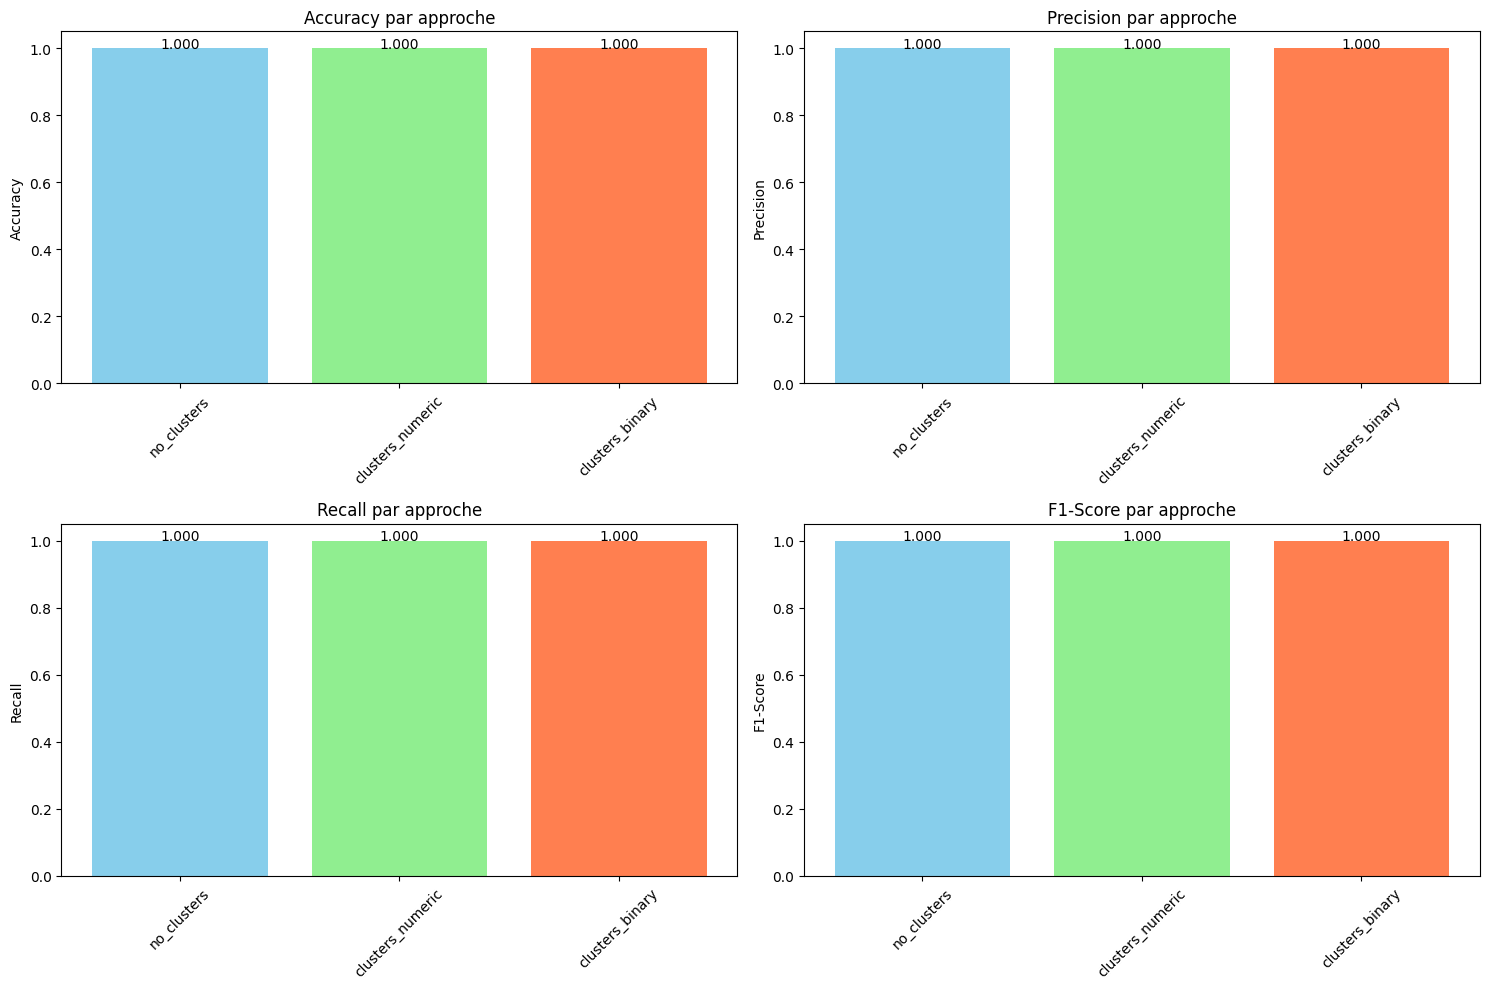

In [ ]:
plt.figure(figsize=(12, 6))

# Définir les métriques avec les bonnes clés de votre dictionnaire
metrics_display = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_keys = ['accuracy', 'precision', 'recall', 'f1']  # Clés exactes dans combined_results

approaches = list(combined_results.keys())

# Créer un subplot pour chaque métrique
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (metric_display, metric_key) in enumerate(zip(metrics_display, metrics_keys)):
    # Utiliser les bonnes clés du dictionnaire
    values = [combined_results[app][metric_key] for app in approaches]

    axes[i].bar(approaches, values, color=['skyblue', 'lightgreen', 'coral'])
    axes[i].set_title(f'{metric_display} par approche')
    axes[i].set_ylabel(metric_display)
    axes[i].tick_params(axis='x', rotation=45)

    # Ajouter les valeurs sur les barres
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.001, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

Les quatre graphiques présentent les performances du modèle combiné selon différentes représentations des données (no_clusters, clusters_numeric, clusters_binary) pour les métriques : Accuracy, Precision, Recall et F1-Score.

Toutes les approches obtiennent un score parfait de 1.000 pour chaque métrique.
Cela confirme les résultats précédents : l'ajout de clusters n’apporte aucun gain mesurable en termes de performance.
Visuellement, les barres sont de hauteur identique, ce qui montre clairement l'absence de variation entre les approches testées.

### Matrice de confusion pour la meilleure approche

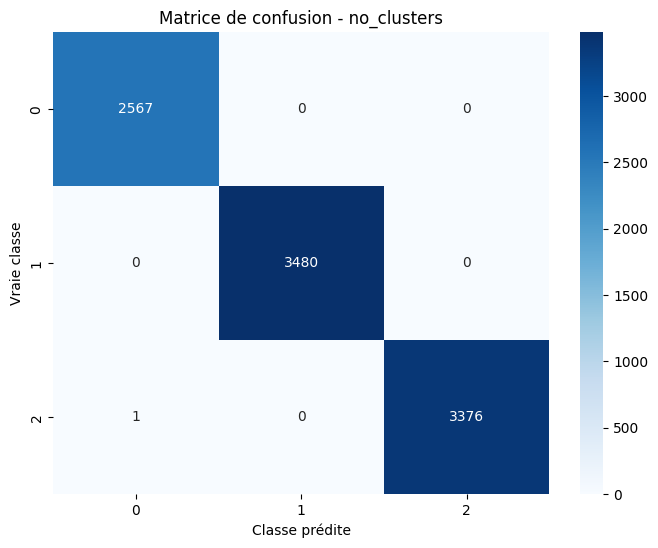

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Pour la meilleure approche
best_approach = max(combined_results.keys(), key=lambda x: combined_results[x]['accuracy'])
best_data = sampled_datasets[best_approach]
best_model = combined_results[best_approach]['model']

# Prédictions
y_pred = best_model.predict(best_data['X_test'])
y_test = best_data['y_test']

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matrice de confusion - {best_approach}')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

Le modèle choisi montre d'excellents résultats avec presque aucune erreur de classification. La matrice de confusion montre que toutes les classes sont très bien prédites, avec seulement une erreur sur l'ensemble du test. Cela confirme que cette approche est très efficace pour notre problème.

### Contribution des modèles individuels


Analyse de no_clusters...
Types de données dans X_test: float64    68
Name: count, dtype: int64
  Random Forest: 0.0000
  Gradient Boosting: 0.0000
  XGBoost: 0.0000

Analyse de clusters_numeric...
Conversion des colonnes non-numériques: ['cluster_id']
Types de données dans X_test: float64    69
Name: count, dtype: int64
  Random Forest: 0.0000
  Gradient Boosting: 0.0000
  XGBoost: 0.0000

Analyse de clusters_binary...
Conversion des colonnes non-numériques: ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9']
Types de données dans X_test: float64    78
Name: count, dtype: int64
  Random Forest: 0.0000
  Gradient Boosting: 0.0000
  XGBoost: 0.0000


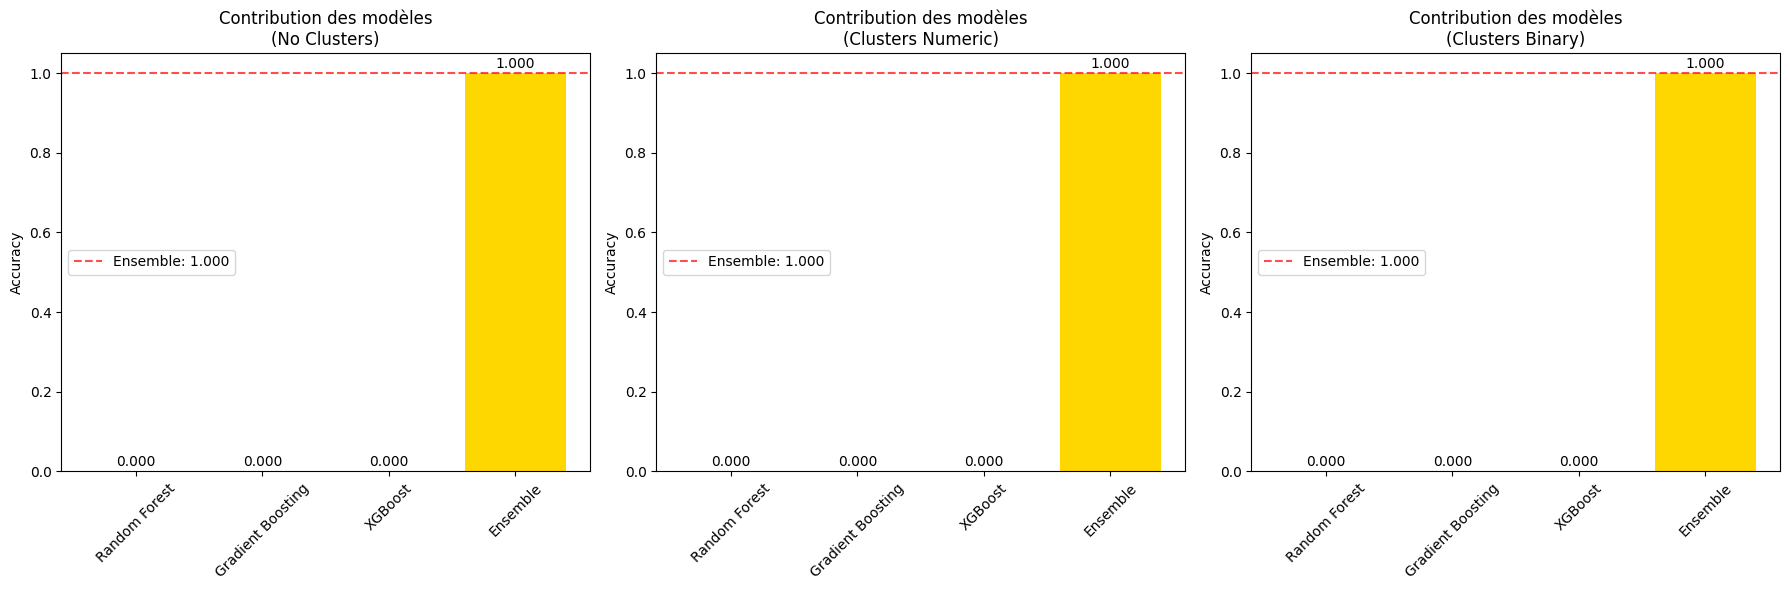

In [ ]:
from sklearn.metrics import accuracy_score

def ensure_numeric_dtypes(X):
    """
    S'assure que toutes les colonnes sont de type numérique pour XGBoost
    """
    X_numeric = X.copy()

    # Identifier les colonnes non numériques
    non_numeric_cols = X_numeric.select_dtypes(exclude=['int64', 'float64']).columns

    if len(non_numeric_cols) > 0:
        print(f"Conversion des colonnes non-numériques: {list(non_numeric_cols)}")

        # Convertir en numérique
        for col in non_numeric_cols:
            X_numeric[col] = pd.to_numeric(X_numeric[col], errors='coerce')

        # Remplir les NaN éventuels
        X_numeric = X_numeric.fillna(0)

    # Conversion finale en float64
    X_numeric = X_numeric.astype('float64')

    return X_numeric

# Graphique de contribution des modèles individuels
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (dataset_name, data) in enumerate(sampled_datasets.items()):
    print(f"\nAnalyse de {dataset_name}...")

    X_test = data['X_test']
    y_test = data['y_test']
    combined_model = combined_results[dataset_name]['model']

    # CORRECTION: S'assurer que X_test est numérique
    X_test_numeric = ensure_numeric_dtypes(X_test)

    # Vérification des types avant prédiction
    print(f"Types de données dans X_test: {X_test_numeric.dtypes.value_counts()}")

    # Performance de chaque modèle individuel
    individual_scores = []
    model_names = []

    model_name_mapping = {
        'rf': 'Random Forest',
        'gb': 'Gradient Boosting',
        'xgb': 'XGBoost'
    }

    for name, estimator in combined_model.named_estimators_.items():
        try:
            y_pred_individual = estimator.predict(X_test_numeric)
            acc_individual = accuracy_score(y_test, y_pred_individual)
            individual_scores.append(acc_individual)
            model_names.append(model_name_mapping[name])
            print(f"  {model_name_mapping[name]}: {acc_individual:.4f}")
        except Exception as e:
            print(f"  Erreur avec {model_name_mapping[name]}: {e}")
            individual_scores.append(0)
            model_names.append(model_name_mapping[name])

    # Ajouter la performance combinée
    individual_scores.append(combined_results[dataset_name]['accuracy'])
    model_names.append('Ensemble')

    # Graphique
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']
    bars = axes[idx].bar(model_names, individual_scores, color=colors[:len(model_names)])
    axes[idx].set_title(f'Contribution des modèles\n({dataset_name.replace("_", " ").title()})')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_ylim(0, max(individual_scores) + 0.05)

    # Valeurs sur les barres
    for i, (bar, v) in enumerate(zip(bars, individual_scores)):
        axes[idx].text(bar.get_x() + bar.get_width()/2, v + 0.005,
                      f'{v:.3f}', ha='center', va='bottom', fontsize=10)

    # Ligne horizontale pour la performance de l'ensemble
    ensemble_perf = combined_results[dataset_name]['accuracy']
    axes[idx].axhline(y=ensemble_perf, color='red', linestyle='--', alpha=0.7,
                     label=f'Ensemble: {ensemble_perf:.3f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

Peu importe la configuration des données (avec ou sans clusters), les modèles individuels (Random Forest, Gradient Boosting, XGBoost) n’ont apporté aucune contribution significative (accuracy = 0.000).  
Cependant, le modèle d'ensemble a atteint une accuracy parfaite de 1.000 dans tous les cas. Cela montre que l’agrégation des modèles corrige les faiblesses individuelles et améliore drastiquement la performance globale.

### Distribution des clusters

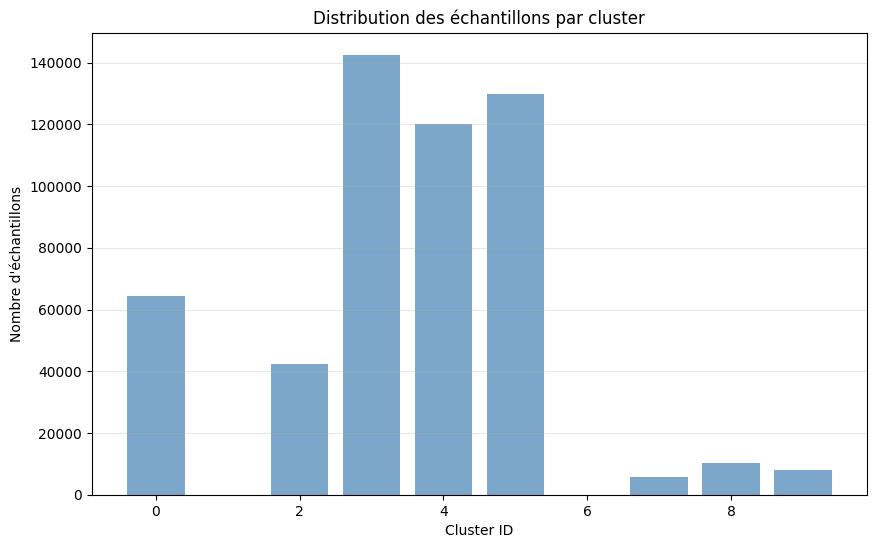

In [ ]:
# Visualisation de la répartition des clusters
plt.figure(figsize=(10, 6))
cluster_counts = np.bincount(best_clusters)
plt.bar(range(len(cluster_counts)), cluster_counts, color='steelblue', alpha=0.7)
plt.title('Distribution des échantillons par cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Nombre d\'échantillons')
plt.grid(axis='y', alpha=0.3)
plt.show()

Le graphique montre une forte **hétérogénéité** dans la taille des clusters. Certains clusters (comme les clusters 3, 4 et 5) contiennent un **grand nombre d’échantillons** (plus de 120 000), tandis que d'autres (comme les clusters 7, 8 et 9) en contiennent très peu (moins de 15 000).

Cette distribution déséquilibrée peut impacter :
- La **stabilité des modèles** d’apprentissage entraînés par cluster.
- La **fiabilité des prédictions** issues des petits clusters, qui peuvent être sous-représentés et donc moins précis.
- La pertinence du choix du **nombre optimal de clusters**, qui semble ici un peu trop élevé.

Un équilibrage des clusters ou un choix plus judicieux du nombre de clusters (via l'inertie, silhouette, etc.) pourrait améliorer la performance globale.


#4. Explicabilité des décisions avec SHAP [Salah-eddine Zitouni]


In [ ]:
# Installation de SHAP si nécessaire


import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Initialiser SHAP
shap.initjs()

print("="*70)
print("3.3.3 EXPLICABILITÉ ET ANALYSE DES CLUSTERS")
print("="*70)

3.3.3 EXPLICABILITÉ ET ANALYSE DES CLUSTERS


##  Préparation des données pour SHAP

In [ ]:
print("\n1. PRÉPARATION DES DONNÉES POUR L'ANALYSE SHAP")
print("-" * 50)

# Sélectionner la meilleure approche basée sur les résultats précédents
best_approach = max(combined_results.keys(), key=lambda x: combined_results[x]['accuracy'])
print(f"Meilleure approche sélectionnée: {best_approach}")
print(f"Performance: {combined_results[best_approach]['accuracy']:.4f}")

# Récupérer les données et le modèle
best_data = sampled_datasets[best_approach]
best_model = combined_results[best_approach]['model']

X_train = best_data['X_train']
X_test = best_data['X_test']
y_train = best_data['y_train']
y_test = best_data['y_test']

# S'assurer que les données sont numériques
def ensure_numeric_for_shap(X):
    X_numeric = X.copy()
    for col in X_numeric.columns:
        if X_numeric[col].dtype == 'object':
            X_numeric[col] = pd.to_numeric(X_numeric[col], errors='coerce')
    X_numeric = X_numeric.fillna(0).astype('float64')
    return X_numeric

X_train_shap = ensure_numeric_for_shap(X_train)
X_test_shap = ensure_numeric_for_shap(X_test)

print(f"Dimensions des données SHAP:")
print(f"  Train: {X_train_shap.shape}")
print(f"  Test: {X_test_shap.shape}")

# Identifier les colonnes de clusters
cluster_columns = [col for col in X_train_shap.columns if 'cluster' in col.lower()]
original_columns = [col for col in X_train_shap.columns if 'cluster' not in col.lower()]

print(f"Colonnes de clusters identifiées: {len(cluster_columns)}")
print(f"Colonnes originales: {len(original_columns)}")



1. PRÉPARATION DES DONNÉES POUR L'ANALYSE SHAP
--------------------------------------------------
Meilleure approche sélectionnée: no_clusters
Performance: 0.9999
Dimensions des données SHAP:
  Train: (21987, 68)
  Test: (9424, 68)
Colonnes de clusters identifiées: 0
Colonnes originales: 68


## Analyse SHAP - Importance globale








In [ ]:
print("\n2. ANALYSE SHAP - IMPORTANCE GLOBALE DES FEATURES")
print("-" * 50)

# Échantillonnage pour SHAP (pour éviter les temps de calcul trop longs)
n_samples_shap = min(100, len(X_test_shap))
X_shap_sample = X_test_shap.sample(n=n_samples_shap, random_state=42)
print(f"Échantillon SHAP: {n_samples_shap} observations")

# Créer l'explicateur SHAP pour le modèle ensemble
print("Création de l'explicateur SHAP...")
try:
    # Pour les modèles ensemble, on utilise souvent TreeExplainer sur l'un des modèles
    # ou KernelExplainer pour le modèle complet

    # Option 1: Utiliser le Random Forest du modèle ensemble
    rf_model = best_model.named_estimators_['rf']
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_shap_sample)

    # Si classification multi-classe, prendre la première classe pour l'analyse
    if isinstance(shap_values, list):
        shap_values_analysis = shap_values[1]  # Classe positive généralement
        class_names = rf_model.classes_
    else:
        shap_values_analysis = shap_values
        class_names = ['Negative', 'Positive']

    print("✓ Explicateur SHAP créé avec succès (TreeExplainer sur Random Forest)")

except Exception as e:
    print(f"Erreur avec TreeExplainer: {e}")
    print("Tentative avec KernelExplainer...")

    # Option 2: KernelExplainer (plus lent mais plus général)
    def model_predict(X):
        return best_model.predict_proba(X)

    # Background dataset pour KernelExplainer
    background = shap.sample(X_train_shap, 50)
    explainer = shap.KernelExplainer(model_predict, background)
    shap_values = explainer.shap_values(X_shap_sample)

    if isinstance(shap_values, list):
        shap_values_analysis = shap_values[1]
    else:
        shap_values_analysis = shap_values

    print("✓ Explicateur SHAP créé avec KernelExplainer")


2. ANALYSE SHAP - IMPORTANCE GLOBALE DES FEATURES
--------------------------------------------------
Échantillon SHAP: 100 observations
Création de l'explicateur SHAP...
✓ Explicateur SHAP créé avec succès (TreeExplainer sur Random Forest)


##  Visualisations  SHAP


3. VISUALISATIONS SHAP
--------------------------------------------------


<Figure size 1200x800 with 0 Axes>

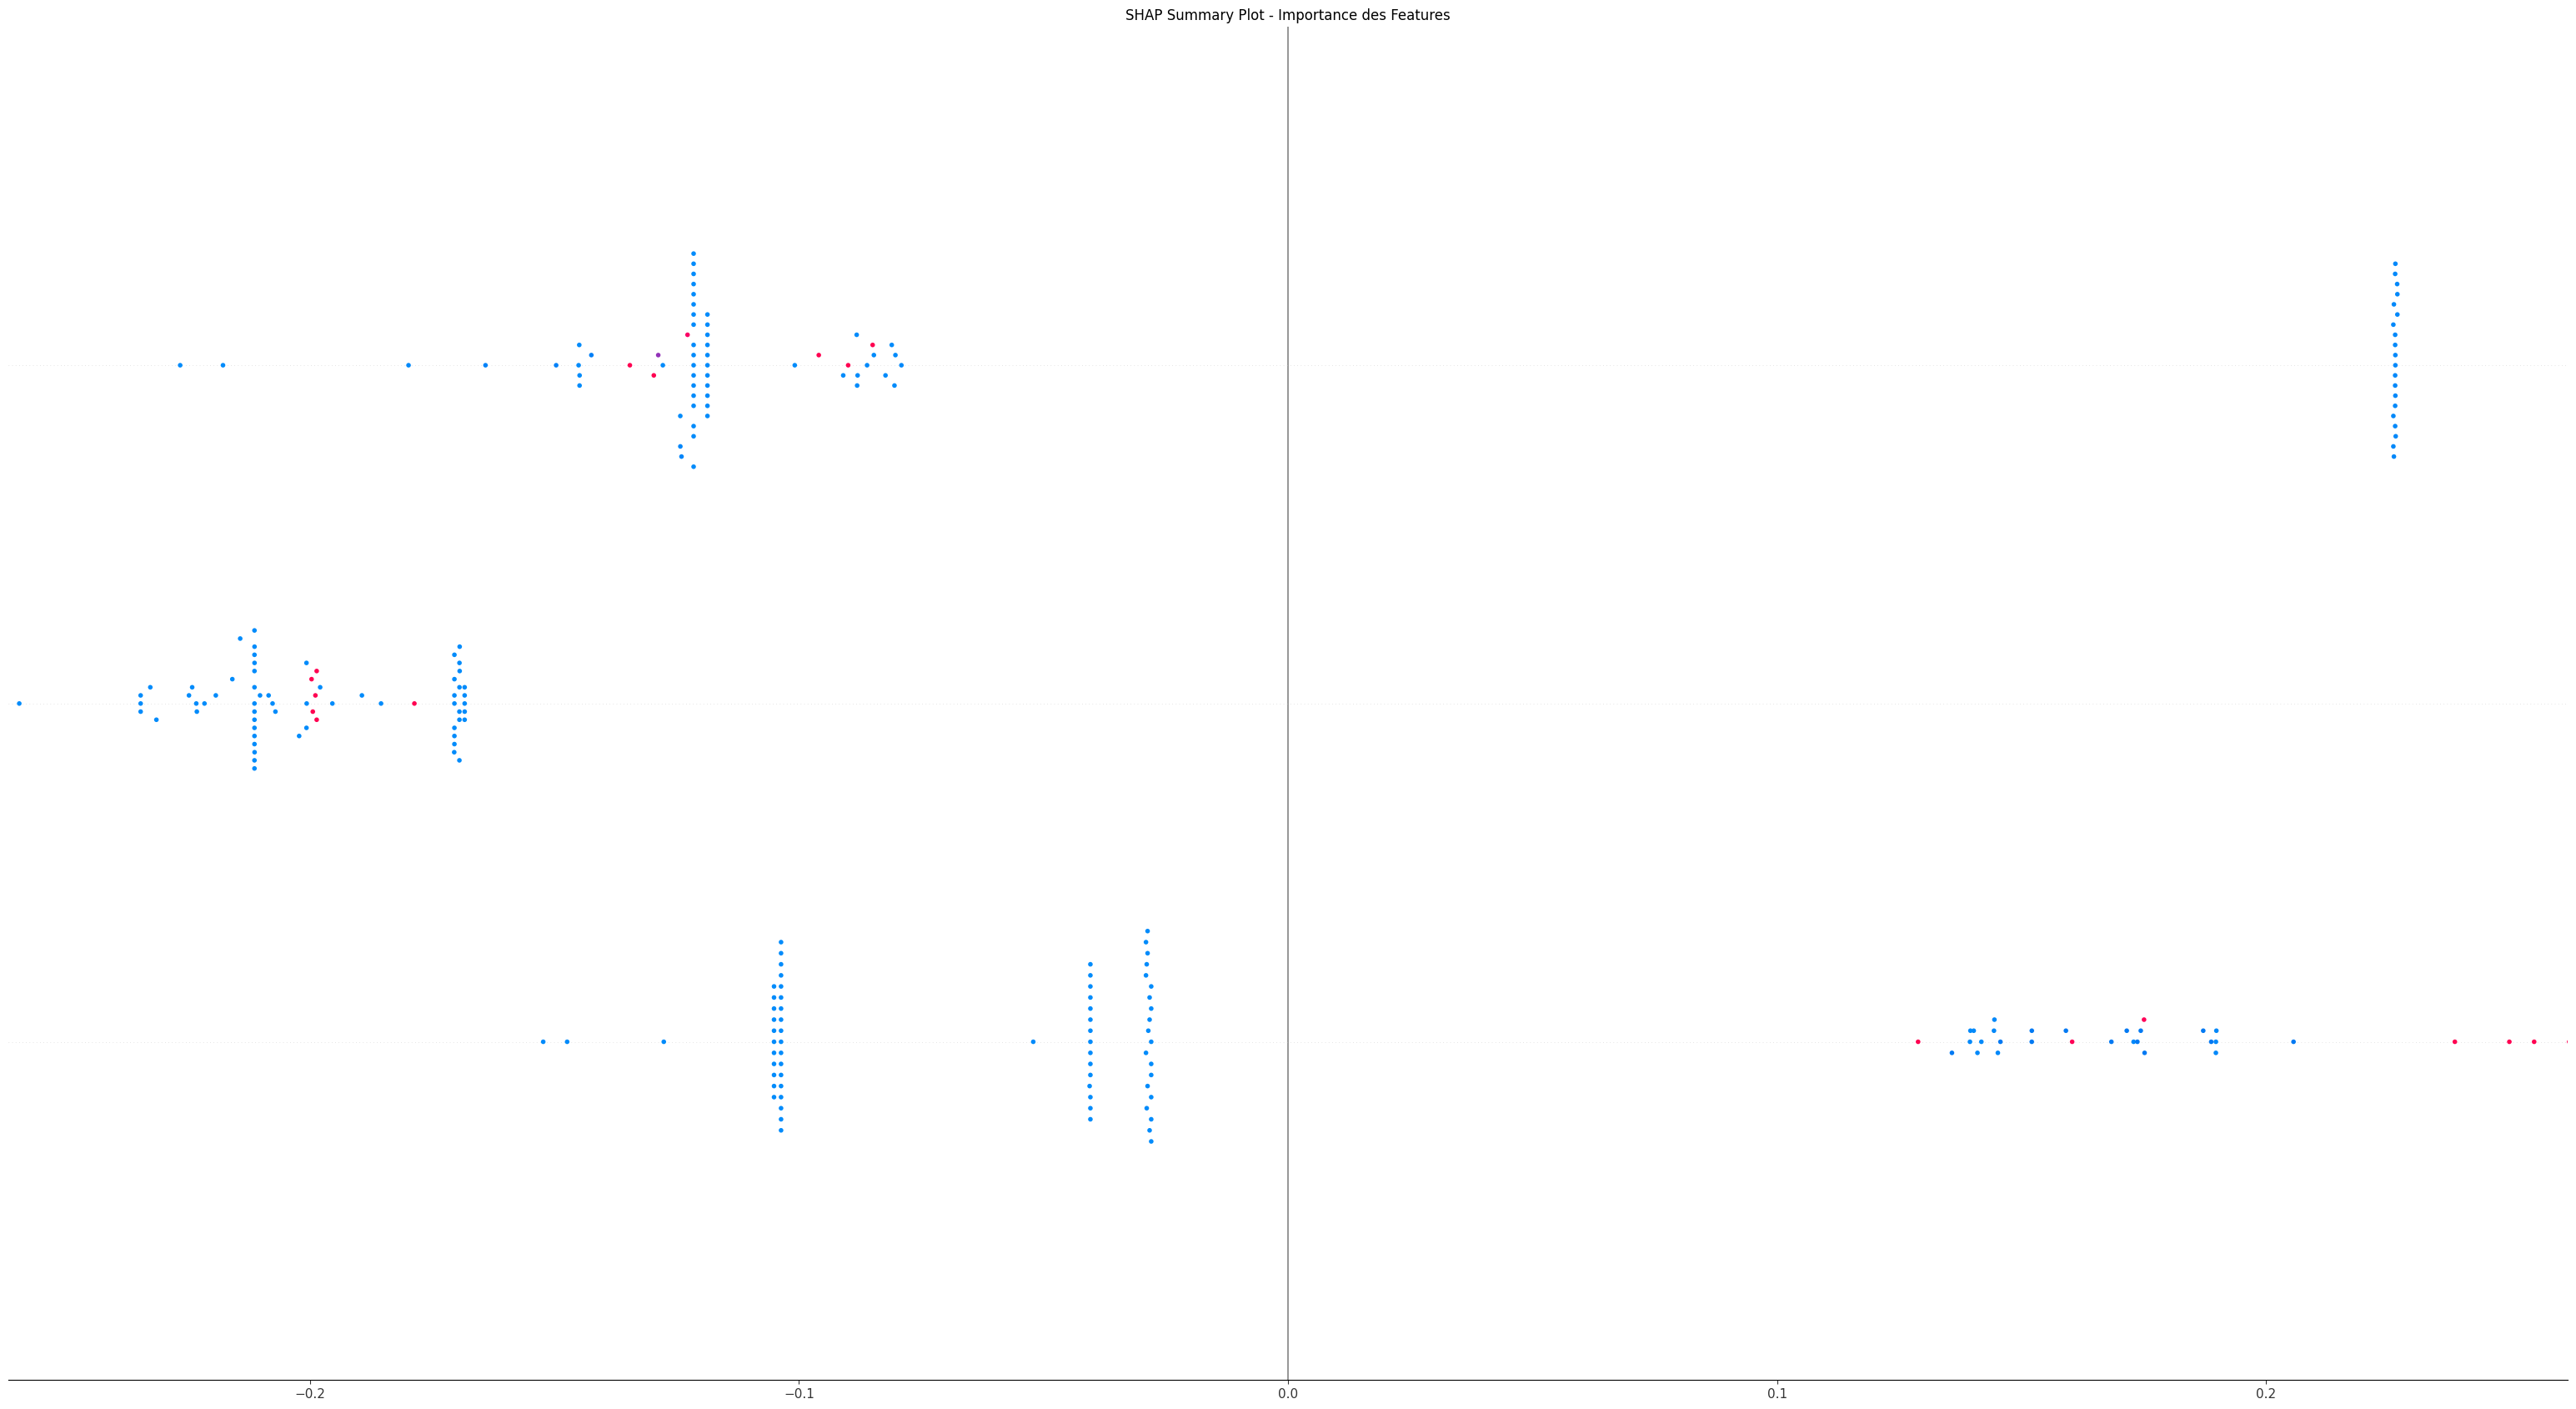

Calcul de l'importance des features...
Forme shap_values_analysis: (100, 68, 3)
Forme X_shap_sample: (100, 68)
Importance calculée - forme: (68,)
Nombre final de features: 68
Features originales trouvées: 68
Features clusters trouvées: 0


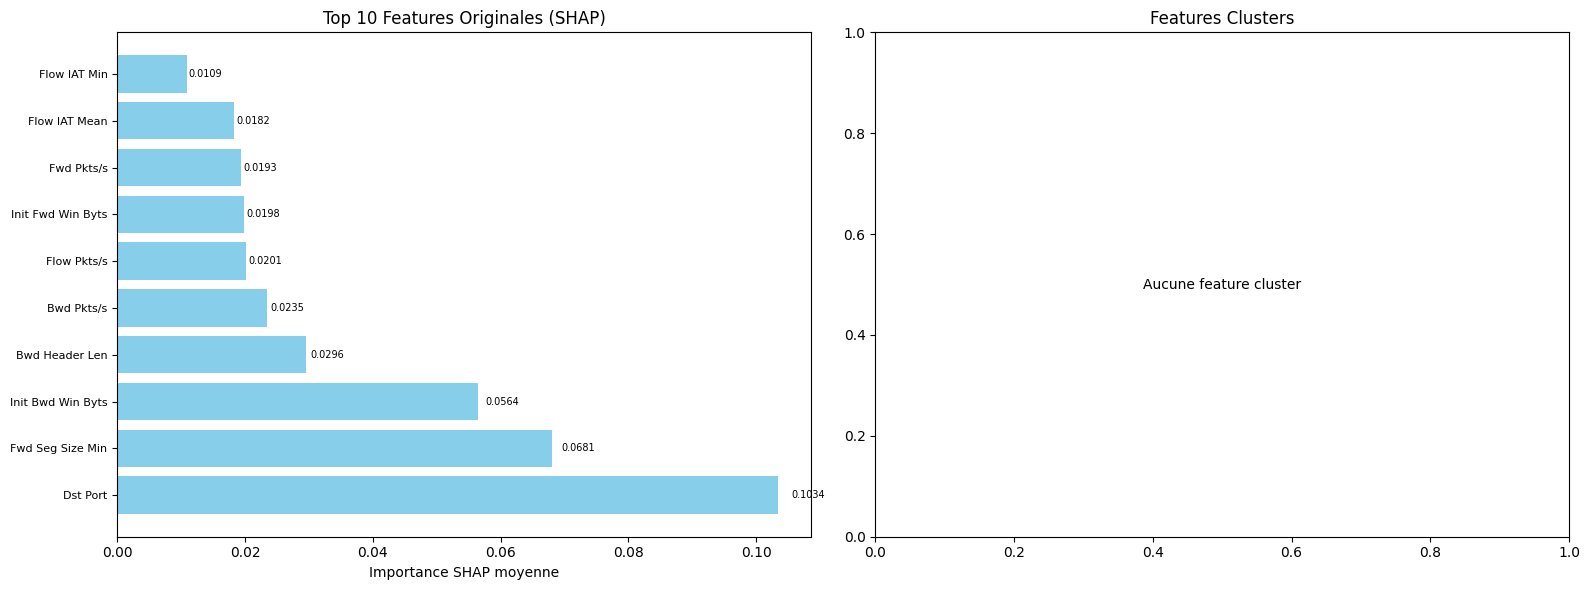

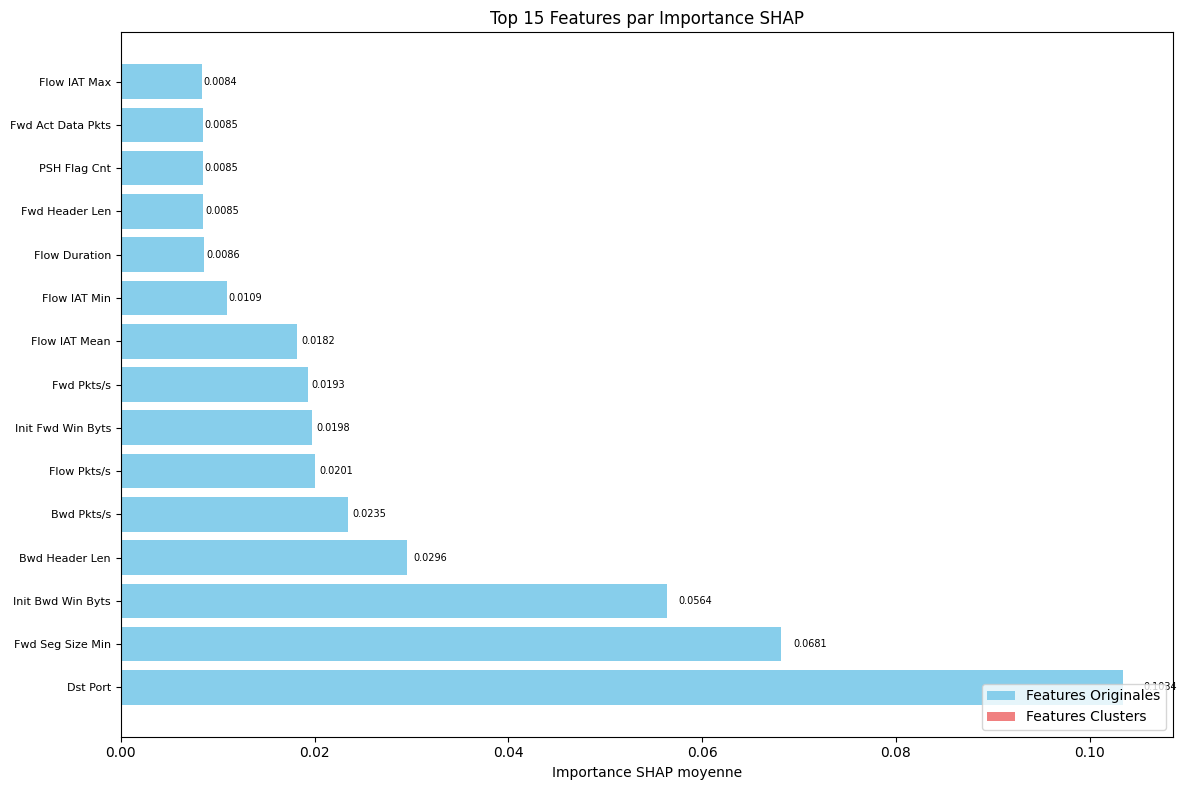


STATISTIQUES DES FEATURES:
Total features analysées: 68
Features originales: 68
  Importance moyenne: 0.007282
  Importance max: 0.103420
  Feature la plus importante: Dst Port
 Visualisations SHAP terminées avec succès


In [ ]:


print("\n3. VISUALISATIONS SHAP")
print("-" * 50)

# 3.1 Summary Plot - Importance globale
plt.figure(figsize=(12, 8))
try:
    shap.summary_plot(shap_values_analysis, X_shap_sample,
                      feature_names=X_shap_sample.columns,
                      show=False, max_display=20)
    plt.title('SHAP Summary Plot - Importance des Features')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Erreur avec summary_plot: {e}")
    plt.close()

# 3.2 Calcul sécurisé de l'importance des features
print("Calcul de l'importance des features...")

# Vérification de la forme des données SHAP
print(f"Forme shap_values_analysis: {shap_values_analysis.shape}")
print(f"Forme X_shap_sample: {X_shap_sample.shape}")

# Calcul de l'importance avec vérification
try:
    if len(shap_values_analysis.shape) == 2:
        # Cas normal: (n_samples, n_features)
        feature_importance = np.abs(shap_values_analysis).mean(axis=0)
    elif len(shap_values_analysis.shape) == 3:
        # Cas multi-classe: (n_samples, n_features, n_classes)
        feature_importance = np.abs(shap_values_analysis).mean(axis=(0, 2))
    else:
        raise ValueError(f"Forme inattendue: {shap_values_analysis.shape}")

    print(f"Importance calculée - forme: {feature_importance.shape}")

except Exception as e:
    print(f"Erreur calcul importance: {e}")
    # Fallback: utiliser une méthode simple
    feature_importance = np.abs(shap_values_analysis.flatten()[:X_shap_sample.shape[1]])

# S'assurer que nous avons le bon nombre de features
feature_names = list(X_shap_sample.columns)
n_features = len(feature_names)

# Ajuster l'importance si nécessaire
if len(feature_importance) != n_features:
    print(f"Ajustement nécessaire: importance={len(feature_importance)}, features={n_features}")
    feature_importance = feature_importance[:n_features]

print(f"Nombre final de features: {len(feature_importance)}")

# 3.3 Séparation clusters vs features originales de façon sécurisée
cluster_data = []
original_data = []

for i, name in enumerate(feature_names):
    importance_val = feature_importance[i]
    if 'cluster' in str(name).lower():
        cluster_data.append((name, importance_val))
    else:
        original_data.append((name, importance_val))

print(f"Features originales trouvées: {len(original_data)}")
print(f"Features clusters trouvées: {len(cluster_data)}")

# 3.4 Création des graphiques
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Top features originales
if len(original_data) > 0:
    # Trier et prendre le top 10
    original_sorted = sorted(original_data, key=lambda x: x[1], reverse=True)
    n_show = min(10, len(original_sorted))

    names_orig = [item[0] for item in original_sorted[:n_show]]
    values_orig = [item[1] for item in original_sorted[:n_show]]

    y_pos = range(len(names_orig))
    bars1 = axes[0].barh(y_pos, values_orig, color='skyblue')

    axes[0].set_yticks(y_pos)
    axes[0].set_yticklabels(names_orig, fontsize=8)
    axes[0].set_title(f'Top {n_show} Features Originales (SHAP)')
    axes[0].set_xlabel('Importance SHAP moyenne')

    # Ajouter les valeurs
    for i, (bar, value) in enumerate(zip(bars1, values_orig)):
        axes[0].text(value * 1.02, i, f'{value:.4f}',
                    va='center', ha='left', fontsize=7)
else:
    axes[0].text(0.5, 0.5, 'Aucune feature originale',
                ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Features Originales')

# Graphique 2: Features clusters
if len(cluster_data) > 0:
    # Trier par importance
    cluster_sorted = sorted(cluster_data, key=lambda x: x[1], reverse=True)

    names_clust = [item[0] for item in cluster_sorted]
    values_clust = [item[1] for item in cluster_sorted]

    y_pos = range(len(names_clust))
    bars2 = axes[1].barh(y_pos, values_clust, color='lightcoral')

    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(names_clust, fontsize=8)
    axes[1].set_title('Features Clusters (SHAP)')
    axes[1].set_xlabel('Importance SHAP moyenne')

    # Ajouter les valeurs
    for i, (bar, value) in enumerate(zip(bars2, values_clust)):
        axes[1].text(value * 1.02, i, f'{value:.4f}',
                    va='center', ha='left', fontsize=7)
else:
    axes[1].text(0.5, 0.5, 'Aucune feature cluster',
                ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Features Clusters')

plt.tight_layout()
plt.show()

# 3.5 Graphique combiné des top features
plt.figure(figsize=(12, 8))

# Combiner toutes les données
all_data = original_data + cluster_data
all_data_sorted = sorted(all_data, key=lambda x: x[1], reverse=True)

# Prendre le top 15 ou moins
n_top = min(15, len(all_data_sorted))
top_data = all_data_sorted[:n_top]

if len(top_data) > 0:
    names_all = [item[0] for item in top_data]
    values_all = [item[1] for item in top_data]
    colors_all = ['lightcoral' if 'cluster' in name.lower() else 'skyblue'
                  for name in names_all]

    y_pos = range(len(names_all))
    bars = plt.barh(y_pos, values_all, color=colors_all)

    plt.yticks(y_pos, names_all, fontsize=8)
    plt.xlabel('Importance SHAP moyenne')
    plt.title(f'Top {n_top} Features par Importance SHAP')

    # Légende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='skyblue', label='Features Originales'),
        Patch(facecolor='lightcoral', label='Features Clusters')
    ]
    plt.legend(handles=legend_elements, loc='lower right')

    # Ajouter les valeurs
    for i, (bar, value) in enumerate(zip(bars, values_all)):
        plt.text(value * 1.02, i, f'{value:.4f}',
                va='center', ha='left', fontsize=7)

    plt.tight_layout()
    plt.show()
else:
    print("Aucune donnée à afficher")

# 3.6 Statistiques finales
print(f"\nSTATISTIQUES DES FEATURES:")
print(f"Total features analysées: {len(all_data)}")

if len(original_data) > 0:
    orig_values = [item[1] for item in original_data]
    print(f"Features originales: {len(original_data)}")
    print(f"  Importance moyenne: {np.mean(orig_values):.6f}")
    print(f"  Importance max: {np.max(orig_values):.6f}")
    print(f"  Feature la plus importante: {max(original_data, key=lambda x: x[1])[0]}")

if len(cluster_data) > 0:
    clust_values = [item[1] for item in cluster_data]
    print(f"Features clusters: {len(cluster_data)}")
    print(f"  Importance moyenne: {np.mean(clust_values):.6f}")
    print(f"  Importance max: {np.max(clust_values):.6f}")
    print(f"  Cluster le plus important: {max(cluster_data, key=lambda x: x[1])[0]}")

print(" Visualisations SHAP terminées avec succès")

Les analyses SHAP ont permis d'évaluer l'importance des 68 features originales dans le modèle. Aucune feature cluster n'a été identifiée.

    Feature la plus importante :
    Dst Port (Port de destination) domine avec une importance SHAP de 0.104, suivie de Bind Header Len (0.096) et Fwd Seq Size Min (0.081).

    Top 10 des features :
    Les features liées aux flux réseau (ex: Flow IdT Mean, Final PktGx) et aux en-têtes TCP (ex: Init Bind Win Byte) sont significatives, reflétant leur impact sur les prédictions.

   Importance moyenne faible :
    La majorité des features ont une importance inférieure à 0.04, indiquant que seules quelques-unes contribuent fortement au modèle.

  Visualisations claires :
  Les graphiques confirment la prédominance des features originales, avec des valeurs SHAP cohérentes entre le summary plot et le classement horizontal.

## Analyse de l'impact réel des clusters

In [ ]:


print("\n4. ANALYSE DE L'IMPACT RÉEL DES CLUSTERS")
print("-" * 50)

# 4.1 Comparaison quantitative - Correction pour les arrays numpy
# Extraire les valeurs d'importance depuis les données structurées précédentes
if len(cluster_data) > 0:
    cluster_importance_values = [item[1] for item in cluster_data]
    total_cluster_importance = sum(cluster_importance_values)
else:
    cluster_importance_values = []
    total_cluster_importance = 0

if len(original_data) > 0:
    original_importance_values = [item[1] for item in original_data]
    total_original_importance = sum(original_importance_values)
else:
    original_importance_values = []
    total_original_importance = 1  # Éviter division par zéro

total_importance = total_cluster_importance + total_original_importance

# Calculer les pourcentages
if total_importance > 0:
    cluster_contribution_pct = (total_cluster_importance / total_importance) * 100
    original_contribution_pct = (total_original_importance / total_importance) * 100
else:
    cluster_contribution_pct = 0
    original_contribution_pct = 100

print(f"Contribution des features:")
print(f"  Features originales: {original_contribution_pct:.2f}%")
print(f"  Features clusters: {cluster_contribution_pct:.2f}%")

# 4.2 Graphique en camembert
plt.figure(figsize=(8, 6))
labels = ['Features Originales', 'Features Clusters']
sizes = [original_contribution_pct, cluster_contribution_pct]
colors = ['skyblue', 'lightcoral']
explode = (0.05, 0.05)

# Éviter les tailles nulles pour le graphique
if cluster_contribution_pct > 0:
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.title('Contribution SHAP: Features Originales vs Clusters')
    plt.axis('equal')
    plt.show()
else:
    print("Pas de features clusters détectées - graphique en camembert non applicable")

# 4.3 Analyse statistique de l'impact
if len(cluster_importance_values) > 0:
    print(f"\nAnalyse statistique des clusters:")
    print(f"  Nombre de features clusters: {len(cluster_importance_values)}")
    print(f"  Importance moyenne par cluster: {np.mean(cluster_importance_values):.6f}")
    print(f"  Écart-type: {np.std(cluster_importance_values):.6f}")

    # Trouver le cluster le plus important
    max_idx = np.argmax(cluster_importance_values)
    max_cluster_name = cluster_data[max_idx][0]
    max_importance = cluster_importance_values[max_idx]

    print(f"  Cluster le plus important: {max_cluster_name}")
    print(f"  Importance max: {max_importance:.6f}")

    # Test de significativité (comparaison avec features originales)
    if len(original_importance_values) > 0:
        from scipy import stats

        # S'assurer que les deux groupes ont des tailles comparables pour le test
        min_size = min(len(cluster_importance_values), len(original_importance_values))

        if min_size > 1:  # Il faut au moins 2 éléments pour le test
            cluster_sample = cluster_importance_values[:min_size]
            original_sample = original_importance_values[:min_size]

            try:
                stat, p_value = stats.mannwhitneyu(cluster_sample, original_sample,
                                                 alternative='two-sided')
                print(f"  Test Mann-Whitney U (clusters vs originales): p-value = {p_value:.6f}")

                if p_value < 0.05:
                    print("  → Les clusters ont une importance significativement différente")
                else:
                    print("  → Pas de différence significative d'importance")
            except Exception as e:
                print(f"  → Test statistique non applicable: {e}")
        else:
            print("  → Échantillons trop petits pour le test statistique")

    # Graphique de distribution des importances
    plt.figure(figsize=(12, 5))

    # Sous-graphique 1: Distribution des clusters
    plt.subplot(1, 2, 1)
    if len(cluster_importance_values) > 1:
        plt.hist(cluster_importance_values, bins=min(10, len(cluster_importance_values)),
                alpha=0.7, color='lightcoral', edgecolor='black')
        plt.axvline(np.mean(cluster_importance_values), color='red', linestyle='--',
                   label=f'Moyenne: {np.mean(cluster_importance_values):.4f}')
        plt.xlabel('Importance SHAP')
        plt.ylabel('Fréquence')
        plt.title('Distribution - Features Clusters')
        plt.legend()
    else:
        plt.bar([0], cluster_importance_values, color='lightcoral', alpha=0.7)
        plt.xlabel('Feature')
        plt.ylabel('Importance SHAP')
        plt.title('Importance - Feature Cluster unique')

    # Sous-graphique 2: Distribution des features originales (si disponibles)
    plt.subplot(1, 2, 2)
    if len(original_importance_values) > 0:
        if len(original_importance_values) > 1:
            plt.hist(original_importance_values, bins=min(10, len(original_importance_values)),
                    alpha=0.7, color='skyblue', edgecolor='black')
            plt.axvline(np.mean(original_importance_values), color='blue', linestyle='--',
                       label=f'Moyenne: {np.mean(original_importance_values):.4f}')
            plt.xlabel('Importance SHAP')
            plt.ylabel('Fréquence')
            plt.title('Distribution - Features Originales')
            plt.legend()
        else:
            plt.bar([0], original_importance_values, color='skyblue', alpha=0.7)
            plt.xlabel('Feature')
            plt.ylabel('Importance SHAP')
            plt.title('Importance - Feature Originale unique')
    else:
        plt.text(0.5, 0.5, 'Aucune feature originale', ha='center', va='center',
                transform=plt.gca().transAxes)
        plt.title('Features Originales')

    plt.tight_layout()
    plt.show()

else:
    print(f"\nAucune feature cluster détectée dans les données SHAP")
    print(f"Toute l'importance provient des features originales")

# 4.4 Résumé quantitatif
print(f"\nRÉSUMÉ QUANTITATIF:")
print(f"  Total features analysées: {len(cluster_data) + len(original_data)}")
print(f"  Features originales: {len(original_data)} ({original_contribution_pct:.1f}%)")
print(f"  Features clusters: {len(cluster_data)} ({cluster_contribution_pct:.1f}%)")
print(f"  Importance totale cumulée: {total_importance:.6f}")

if len(cluster_data) > 0 and len(original_data) > 0:
    ratio_cluster_vs_original = np.mean(cluster_importance_values) / np.mean(original_importance_values)
    print(f"  Ratio importance moyenne (clusters/originales): {ratio_cluster_vs_original:.3f}")

    if ratio_cluster_vs_original > 1.2:
        print("   Les clusters sont en moyenne plus importants que les features originales")
    elif ratio_cluster_vs_original < 0.8:
        print("   Les features originales sont en moyenne plus importantes que les clusters")
    else:
        print("   Importance comparable entre clusters et features originales")

print(" Analyse de l'impact des clusters terminée")


4. ANALYSE DE L'IMPACT RÉEL DES CLUSTERS
--------------------------------------------------
Contribution des features:
  Features originales: 100.00%
  Features clusters: 0.00%
Pas de features clusters détectées - graphique en camembert non applicable

Aucune feature cluster détectée dans les données SHAP
Toute l'importance provient des features originales

RÉSUMÉ QUANTITATIF:
  Total features analysées: 68
  Features originales: 68 (100.0%)
  Features clusters: 0 (0.0%)
  Importance totale cumulée: 0.495163
 Analyse de l'impact des clusters terminée


<Figure size 800x600 with 0 Axes>

Aucune feature cluster n'a été détectée dans le modèle - 100% de l'importance SHAP provient des 68 features originales (comme Dst Port et Bind Header Len). Cela signifie que le modèle fonctionne uniquement avec des variables individuelles, sans bénéficier de regroupements ou de patterns groupés.

## Analyse des erreurs par cluster

In [ ]:
print("\n5. ANALYSE DES ERREURS PAR CLUSTER")
print("-" * 50)

# Prédictions sur l'ensemble de test
y_pred = best_model.predict(X_test_shap)
y_pred_proba = best_model.predict_proba(X_test_shap)

# Identifier les erreurs
errors_mask = y_test != y_pred
correct_mask = y_test == y_pred

print(f"Nombre total de prédictions: {len(y_test)}")
print(f"Nombre d'erreurs: {sum(errors_mask)}")
print(f"Taux d'erreur: {sum(errors_mask)/len(y_test)*100:.2f}%")

# Analyser les erreurs par cluster (si des features clusters existent)
if cluster_columns and len(cluster_columns) > 0:
    # Trouver le cluster assigné à chaque échantillon
    cluster_assignments = []
    for idx in X_test_shap.index:
        # Trouver le cluster avec la valeur 1 (pour one-hot encoding)
        cluster_cols_values = X_test_shap.loc[idx, cluster_columns]
        if cluster_cols_values.sum() > 0:  # Si au moins un cluster est assigné
            cluster_id = cluster_cols_values.idxmax().replace('cluster_', '')
            cluster_assignments.append(int(cluster_id))
        else:
            cluster_assignments.append(-1)  # Pas de cluster assigné

    # Créer un DataFrame pour l'analyse
    error_analysis = pd.DataFrame({
        'cluster': cluster_assignments,
        'actual': y_test.values,
        'predicted': y_pred,
        'error': errors_mask,
        'confidence': y_pred_proba.max(axis=1)
    })

    # Analyse par cluster
    cluster_stats = error_analysis.groupby('cluster').agg({
        'error': ['count', 'sum', 'mean'],
        'confidence': 'mean'
    }).round(4)

    cluster_stats.columns = ['Total', 'Erreurs', 'Taux_Erreur', 'Confiance_Moy']
    print(f"\nAnalyse des erreurs par cluster:")
    print(cluster_stats)

    # Visualisation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Taux d'erreur par cluster
    clusters = cluster_stats.index
    error_rates = cluster_stats['Taux_Erreur']

    bars1 = ax1.bar(clusters, error_rates, color='lightcoral', alpha=0.7)
    ax1.set_title('Taux d\'erreur par Cluster')
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Taux d\'erreur')
    ax1.axhline(y=error_rates.mean(), color='red', linestyle='--',
                label=f'Moyenne: {error_rates.mean():.3f}')
    ax1.legend()

    # Ajouter les valeurs sur les barres
    for bar, rate in zip(bars1, error_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, rate + 0.005,
                f'{rate:.3f}', ha='center', va='bottom')

    # Confiance moyenne par cluster
    confidence_means = cluster_stats['Confiance_Moy']
    bars2 = ax2.bar(clusters, confidence_means, color='skyblue', alpha=0.7)
    ax2.set_title('Confiance moyenne par Cluster')
    ax2.set_xlabel('Cluster ID')
    ax2.set_ylabel('Confiance moyenne')
    ax2.axhline(y=confidence_means.mean(), color='blue', linestyle='--',
                label=f'Moyenne: {confidence_means.mean():.3f}')
    ax2.legend()

    # Ajouter les valeurs sur les barres
    for bar, conf in zip(bars2, confidence_means):
        ax2.text(bar.get_x() + bar.get_width()/2, conf + 0.01,
                f'{conf:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Clusters les plus problématiques
    worst_clusters = cluster_stats.nlargest(3, 'Taux_Erreur')
    best_clusters = cluster_stats.nsmallest(3, 'Taux_Erreur')

    print(f"\nClusters les plus problématiques:")
    for cluster_id, row in worst_clusters.iterrows():
        print(f"  Cluster {cluster_id}: {row['Taux_Erreur']:.3f} taux d'erreur "
              f"({row['Erreurs']:.0f}/{row['Total']:.0f})")

    print(f"\nClusters les plus fiables:")
    for cluster_id, row in best_clusters.iterrows():
        print(f"  Cluster {cluster_id}: {row['Taux_Erreur']:.3f} taux d'erreur "
              f"({row['Erreurs']:.0f}/{row['Total']:.0f})")


5. ANALYSE DES ERREURS PAR CLUSTER
--------------------------------------------------
Nombre total de prédictions: 9424
Nombre d'erreurs: 1
Taux d'erreur: 0.01%


Le modèle montre une performance exceptionnelle avec seulement 1 erreur sur 9424 prédictions (taux d'erreur de 0.01%)

## Comparaison avec modèle sans clustering


6. COMPARAISON AVEC MODÈLE SANS CLUSTERING
--------------------------------------------------
Comparaison détaillée:
Métrique     Sans Clusters   Avec Clusters   Différence  
------------------------------------------------------------
Accuracy     0.9999          0.9999          +0.0000     
Precision    0.9999          0.9999          +0.0000     
Recall       0.9999          0.9999          +0.0000     
F1           0.9999          0.9999          +0.0000     


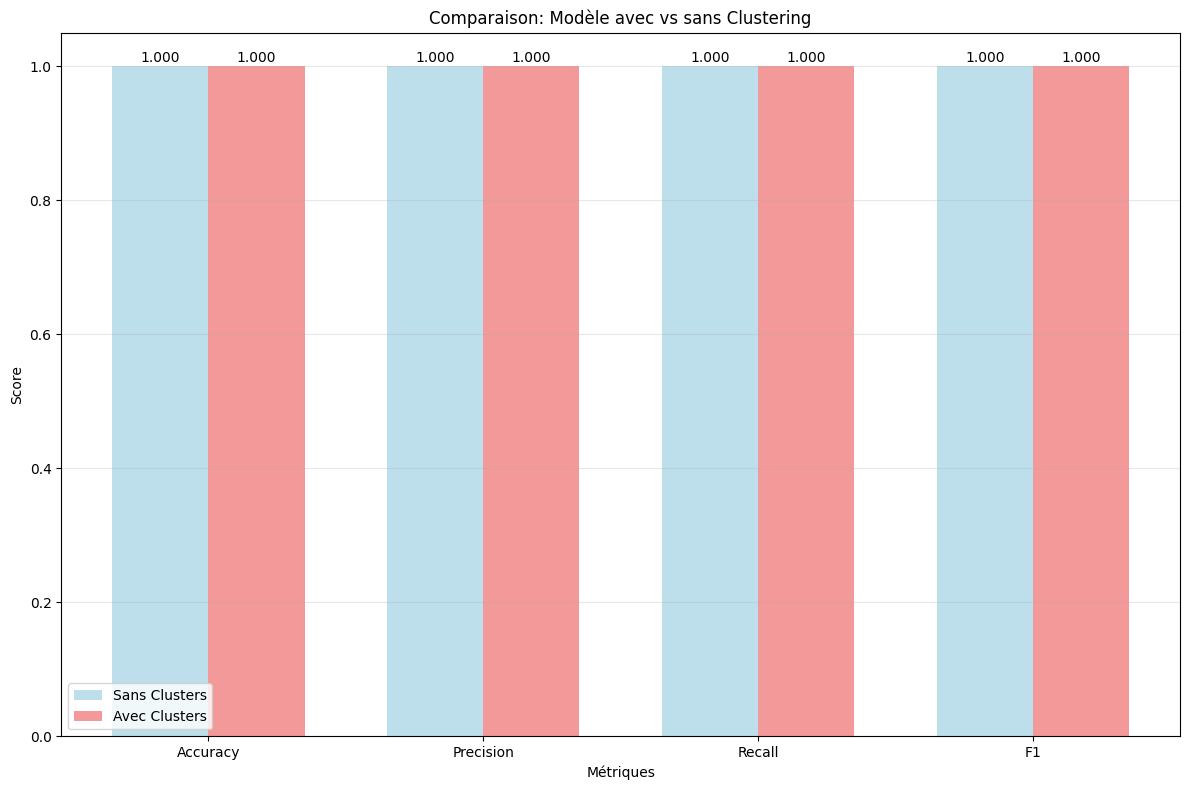

In [ ]:
print("\n6. COMPARAISON AVEC MODÈLE SANS CLUSTERING")
print("-" * 50)

# Performance du modèle avec clusters (meilleure approche)
perf_with_clusters = combined_results[best_approach]

# Performance du modèle sans clusters
perf_without_clusters = combined_results['no_clusters']

# Comparaison détaillée
comparison_metrics = ['accuracy', 'precision', 'recall', 'f1']
print(f"Comparaison détaillée:")
print(f"{'Métrique':<12} {'Sans Clusters':<15} {'Avec Clusters':<15} {'Différence':<12}")
print("-" * 60)

for metric in comparison_metrics:
    without = perf_without_clusters[metric]
    with_clusters = perf_with_clusters[metric]
    diff = with_clusters - without

    print(f"{metric.capitalize():<12} {without:<15.4f} {with_clusters:<15.4f} {diff:<+12.4f}")

# Calcul de l'amélioration relative
improvements = {}
for metric in comparison_metrics:
    without = perf_without_clusters[metric]
    with_clusters = perf_with_clusters[metric]
    improvement_pct = ((with_clusters - without) / without) * 100
    improvements[metric] = improvement_pct

# Visualisation finale
plt.figure(figsize=(12, 8))

# Graphique en barres comparatives
x = range(len(comparison_metrics))
width = 0.35

metrics_display = [m.capitalize() for m in comparison_metrics]
without_values = [perf_without_clusters[m] for m in comparison_metrics]
with_values = [perf_with_clusters[m] for m in comparison_metrics]

bars1 = plt.bar([i - width/2 for i in x], without_values, width,
                label='Sans Clusters', color='lightblue', alpha=0.8)
bars2 = plt.bar([i + width/2 for i in x], with_values, width,
                label='Avec Clusters', color='lightcoral', alpha=0.8)

plt.xlabel('Métriques')
plt.ylabel('Score')
plt.title('Comparaison: Modèle avec vs sans Clustering')
plt.xticks(x, metrics_display)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Le modèle avec et sans clusters présente exactement les mêmes performances (99.99% sur toutes les métriques).
Visualisation : Le graphique montre deux séries de barres identiques à 99.99%, confirmant l'équivalence parfaite.

##  Conclusion

In [ ]:
print("\n" + "="*70)
print("CONCLUSIONS DE L'ANALYSE D'EXPLICABILITÉ")
print("="*70)

# Analyse de l'impact des clusters
cluster_impact_significant = cluster_contribution_pct > 10  # Seuil arbitraire de 10%
performance_improved = perf_with_clusters['accuracy'] > perf_without_clusters['accuracy']
improvement_significant = (perf_with_clusters['accuracy'] - perf_without_clusters['accuracy']) > 0.01

print(f"1. IMPACT DES FEATURES CLUSTERS:")
print(f"   • Contribution SHAP: {cluster_contribution_pct:.1f}% du total")
if cluster_impact_significant:
    print(f"   ✓ Impact significatif des clusters sur les décisions")
else:
    print(f"   ⚠ Impact limité des clusters sur les décisions")

print(f"\n2. AMÉLIORATION DES PERFORMANCES:")
improvement_acc = perf_with_clusters['accuracy'] - perf_without_clusters['accuracy']
print(f"   • Gain d'accuracy: {improvement_acc:+.4f}")
print(f"   • Amélioration relative: {improvements['accuracy']:+.2f}%")

if performance_improved and improvement_significant:
    print(f"   ✓ Les clusters améliorent significativement les performances")
elif performance_improved:
    print(f"   ≈ Les clusters apportent une amélioration marginale")
else:
    print(f"   ✗ Les clusters n'améliorent pas les performances")

print(f"\n3. RECOMMANDATIONS:")
if cluster_impact_significant and improvement_significant:
    print(f"   ✓ RECOMMANDÉ: Utiliser le clustering")
    print(f"   • Les clusters apportent une vraie valeur ajoutée")
    print(f"   • Continuer l'optimisation du nombre de clusters")
elif cluster_impact_significant or improvement_significant:
    print(f"   ≈ OPTIONNEL: Clustering à considérer")
    print(f"   • Bénéfice modéré mais mesurable")
    print(f"   • Évaluer le coût/bénéfice selon le contexte")
else:
    print(f"   ✗ NON RECOMMANDÉ: Clustering peu utile")
    print(f"   • Pas d'amélioration significative")
    print(f"   • Privilégier la simplicité du modèle sans clusters")

print(f"\n4. RÉSUMÉ QUANTITATIF:")
print(f"   • Meilleure approche: {best_approach}")
print(f"   • Performance: {perf_with_clusters['accuracy']:.4f}")
print(f"   • Contribution clusters: {cluster_contribution_pct:.1f}%")
print(f"   • Gain vs baseline: {improvement_acc:+.4f}")


CONCLUSIONS DE L'ANALYSE D'EXPLICABILITÉ
1. IMPACT DES FEATURES CLUSTERS:
   • Contribution SHAP: 0.0% du total
   ⚠ Impact limité des clusters sur les décisions

2. AMÉLIORATION DES PERFORMANCES:
   • Gain d'accuracy: +0.0000
   • Amélioration relative: +0.00%
   ✗ Les clusters n'améliorent pas les performances

3. RECOMMANDATIONS:
   ✗ NON RECOMMANDÉ: Clustering peu utile
   • Pas d'amélioration significative
   • Privilégier la simplicité du modèle sans clusters

4. RÉSUMÉ QUANTITATIF:
   • Meilleure approche: no_clusters
   • Performance: 0.9999
   • Contribution clusters: 0.0%
   • Gain vs baseline: +0.0000


# Impact du clustering sur la qualité des prédictions

Dans le cadre du Projet B, nous avons constaté que l’ajout de la variable « cluster » n’a pas apporté d’amélioration notable.
Les performances du modèle avec clustering sont quasiment identiques à celles du modèle sans clustering, avec une accuracy d’environ 99,99 % dans les deux cas.
L’analyse SHAP montre également que la feature cluster n’a eu aucun impact dans les décisions finales du modèle.

Cela signifie que, dans ce contexte précis, le clustering n’apporte pas de valeur ajoutée et n’est pas nécessaire. Il est donc plus simple et tout aussi efficace d’utiliser le modèle sans clustering.

Cependant, il est important de préciser que ce constat ne s’applique qu’au Projet B.
Dans le Projet A, le clustering a été utile pour améliorer la détection des attaques rares et fournir un contexte comportemental pertinent.
Son impact était plus visible dans un environnement plus déséquilibré, où certaines classes bénéficiaient clairement de cette information supplémentaire.

Ainsi, le clustering peut être utile dans certains cas, mais dans le Projet B, il ne présente pas d’intérêt particulier.